In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#plot_n_b_psth.ipynb
#plot neural and behavior psth

import scipy.io as sio
import scipy.stats as sio_stat
import scipy.interpolate
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt 

import os
import pickle
import sys
import copy

import time
import pylab as pl
from IPython import display

from bmi_dynamics_code import behavior_co_obs as bmi_b
from bmi_dynamics_code import data_for_v as preeyacode
from bmi_dynamics_code import util as bmi_util

import timeit
from sklearn import decomposition as skl_decomp

%matplotlib notebook

In [3]:
%matplotlib notebook

In [4]:
# data_dir = '/Users/vivekathalye/Dropbox/Code/preeya_co_obstacle'
save_dir = r'D:\Dropbox\BMI_co_obs_paper\data\vivek\psth'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

home_dir = r'D:\Dropbox\Code\preeya_co_obstacle'
data_dir = r'D:\Dropbox\Data\preeya_co_obstacle'
data_path = os.path.join(data_dir, 'for_v_df.pkl')
print(os.path.exists(data_path))
d = pickle.load(open(data_path))

#UNPACK: 
decoder = d['decoder']
pre = d['pre']
num_targets = d['num_targets']
sample_period = d['sample_period']
target_hold_time = d['target_hold_time']
num_neurons = d['num_neurons']
target_color = d['target_color']
obs_big = d['obs_big']
obs_small = d['obs_small']
target_r_task = d['target_r_task'] #target_r_task = {0:1.7, 1:2.0}
cursor_r = d['cursor_r']
target_r_eff = d['target_r_eff']
target_pos = d['target_pos']
target_angle = np.arctan2(target_pos[:,1], target_pos[:,0])
target_dist = np.linalg.norm(target_pos, axis=1)
obs_pos = d['obs_pos']

tc_meta = d['tc_meta']
task_list = d['task_list']
num_tasks = len(task_list)
task2idx = d['task2idx']
idx2task = bmi_util.invert_dic(task2idx)
task2tc = d['task2tc']
tc_list = d['tc_list']
df = d['df']
df_label = d['df_label']

task_color = ['k', 'r']

True


In [5]:
save_dir

'D:\\Dropbox\\BMI_co_obs_paper\\data\\vivek\\psth'

<IPython.core.display.Javascript object>


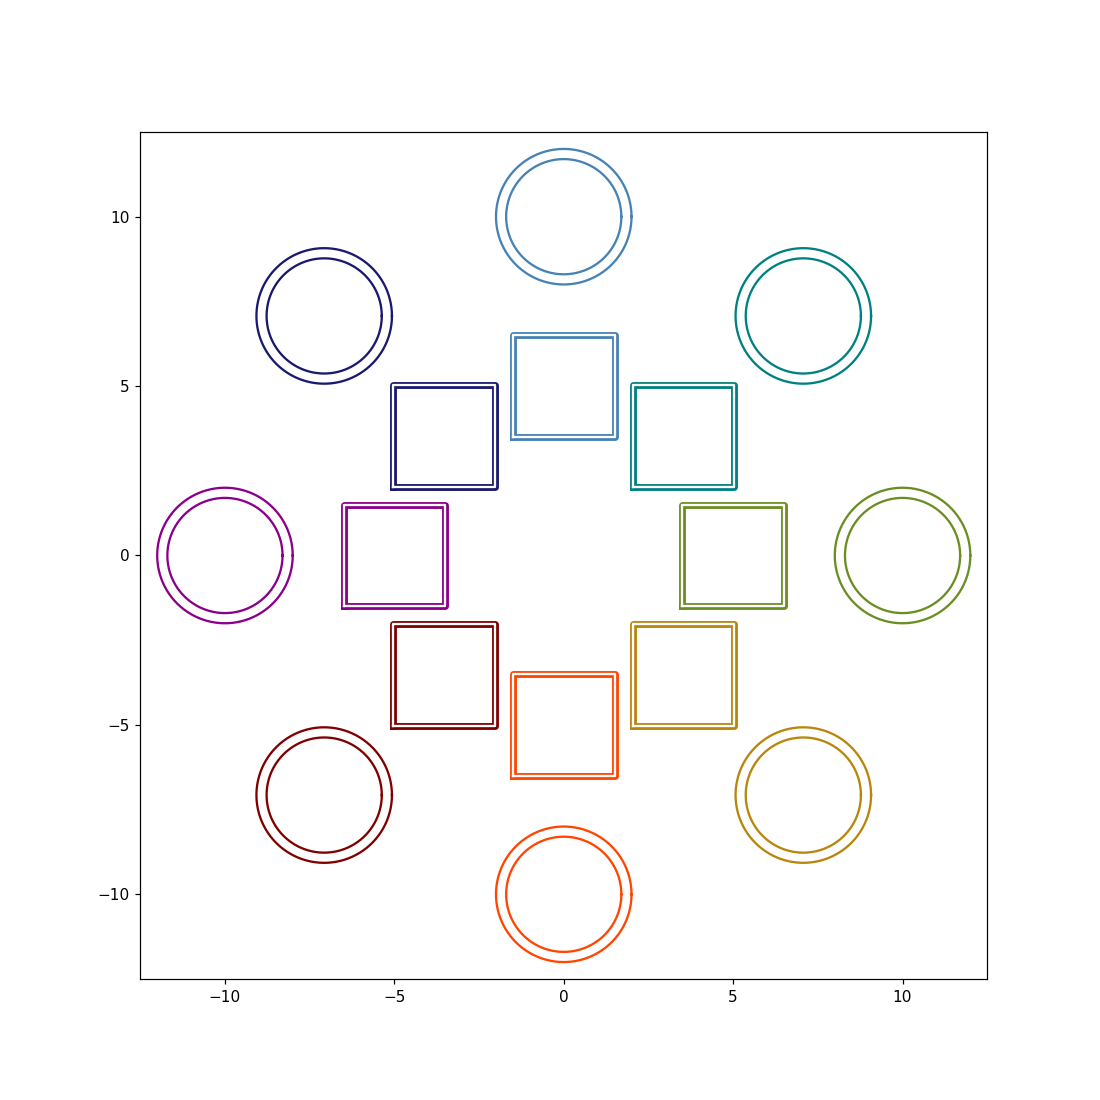

In [6]:
#Plot the targets and obstacles: 
plot_task = True

plot_target = True
plot_obs_big = True
plot_obs_small = False

save_bool = True
plt_ext = ['.eps']

if plot_task:
    plot = {}
    plot['size'] = (10,10)
    plot['xlim'] = (-12.5,12.5)
    plot['ylim'] = (-12.5,12.5)

    plt.figure(figsize=plot['size'])

    if plot_obs_small:
        bmi_util.plot_obstacles(obs_pos, target_color, obs_small*np.ones(num_targets))
    if plot_obs_big:
        bmi_util.plot_obstacles(obs_pos, target_color, obs_big*np.ones(num_targets))
    if plot_target: 
        for task in range(num_tasks):
            bmi_util.plot_targets(target_pos, target_color, target_r_task[task]*np.ones(num_targets))                
    plt.axis('square')
    plt.xlim(plot['xlim'])
    plt.ylim(plot['ylim'])
    plt.show()
    
    if save_bool: 
        plt_name = 'target_obstacle'
        for ext in plt_ext:
            plt.savefig(os.path.join(save_dir, plt_name+ext))

In [91]:
target_r_eff

{0: 1.3, 1: 1.5}

In [111]:
target_r_task


{0: 2.1, 1: 2.5}

In [98]:
cursor_r

{0: 0.4, 1: 0.5}

In [114]:
target_r_eff = copy.copy(target_r_task)
target_r_eff[0] += cursor_r[0]
target_r_eff[1] += cursor_r[1]

In [115]:
target_r_task

{0: 1.7, 1: 2.0}

<IPython.core.display.Javascript object>


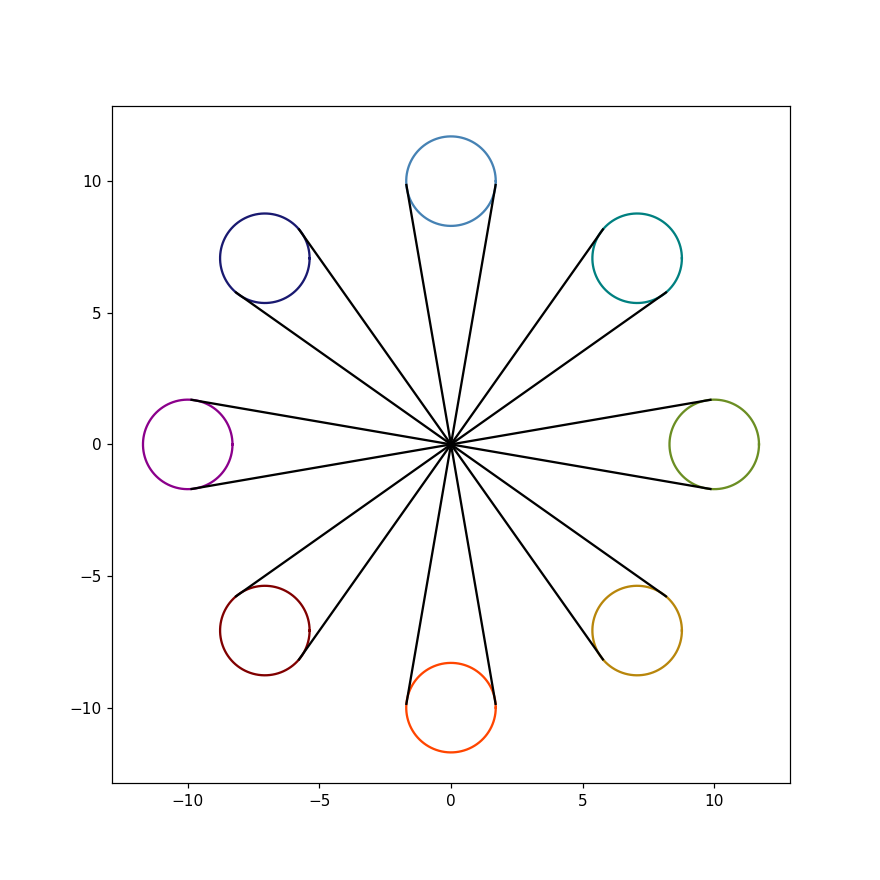

9.752049739225924


In [116]:
#Confirm the angles the cursor can use to hit the target
r=10

#the intersection of: x^2+(y-10)^2=1.7^2, x^2+y^2=100.  solved for using wolfram alpha.
x_sol = 17*(39711)**(0.5)/2000.0
y_sol = 19711.0/2000.0

theta_max = np.arctan2(x_sol, y_sol)
plt.figure(figsize=(8,8))
bmi_util.plot_targets(target_pos, target_color, target_r_task[0]*np.ones(num_targets)) 
for target in range(num_targets):
    mult_list = [1,-1]
    for mult in mult_list:
        theta = target_angle[target]+theta_max*mult
        x = r*np.cos(theta)
        y = r*np.sin(theta)
        plt.plot(np.array([0, x]), np.array([0, y]), 'k')
plt.axis('square')
print(theta_max*180/np.pi)

In [119]:
obs_big

3

angle to avoid obstacle:
23.19859051364819


<IPython.core.display.Javascript object>


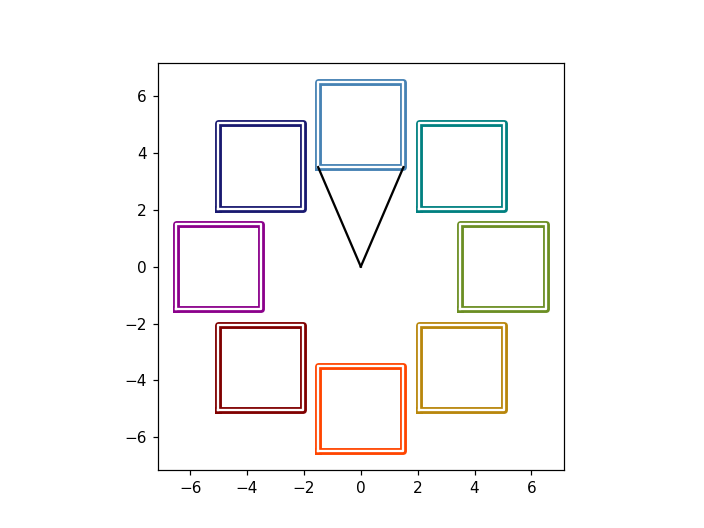

(-7.15, 7.15, -7.15, 7.15)

In [138]:
obs_x = obs_big/2.0
obs_y = 5-obs_big/2.0
obs_theta = np.arctan2(obs_x, obs_y)
print('angle to avoid obstacle:')
print(obs_theta*180/np.pi)

plt.figure()
bmi_util.plot_obstacles(obs_pos, target_color, obs_big*np.ones(num_targets))
x= np.array([0, obs_x])
y=np.array([0, obs_y])
plt.plot(x,y,'k')
x= np.array([0, -obs_x])
y=np.array([0, obs_y])
plt.plot(x,y,'k')
plt.axis('square')

In [137]:
#angle for avoiding obstacle in diagonal positions: 
obs_y = 5
obs_x = ((obs_big**2+obs_big**2)**0.5)/2
obs_theta_diag = np.arctan2(obs_x, obs_y)
print(obs_theta_diag*180/np.pi)

22.98976777360885


In [ ]:
obs_x = obs_big/2.0
obs_y = 5-obs_big/2.0
obs_theta = np.arctan2(obs_x, obs_y)
print('angle to avoid obstacle:')
print(obs_theta*180/np.pi)

plt.figure()
bmi_util.plot_obstacles(obs_pos, target_color, obs_big*np.ones(num_targets))
x= np.array([0, obs_x])
y=np.array([0, obs_y])
plt.plot(x,y,'k')
x= np.array([0, -obs_x])
y=np.array([0, obs_y])
plt.plot(x,y,'k')
plt.axis('square')

<IPython.core.display.Javascript object>


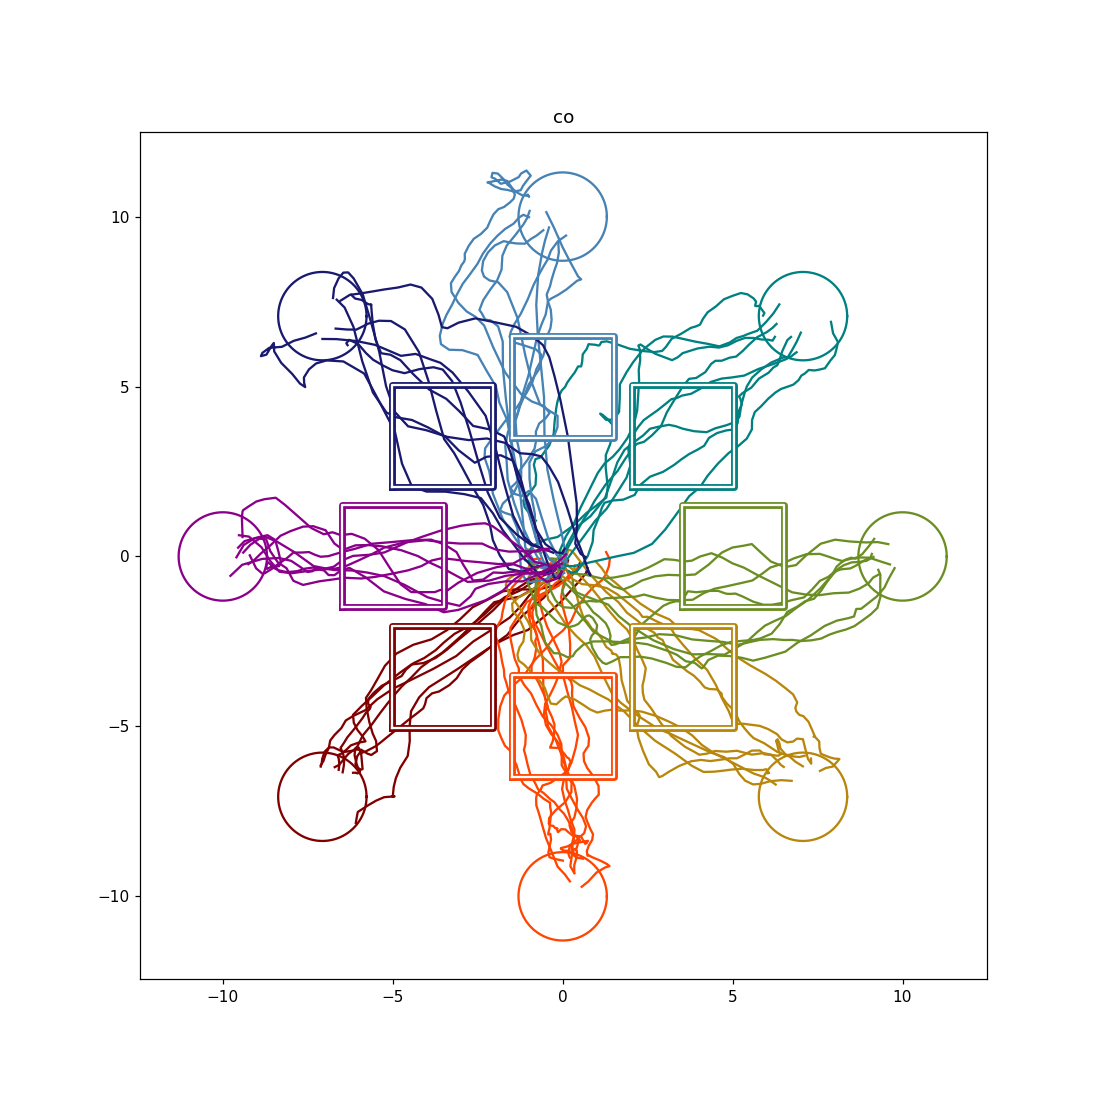

<IPython.core.display.Javascript object>


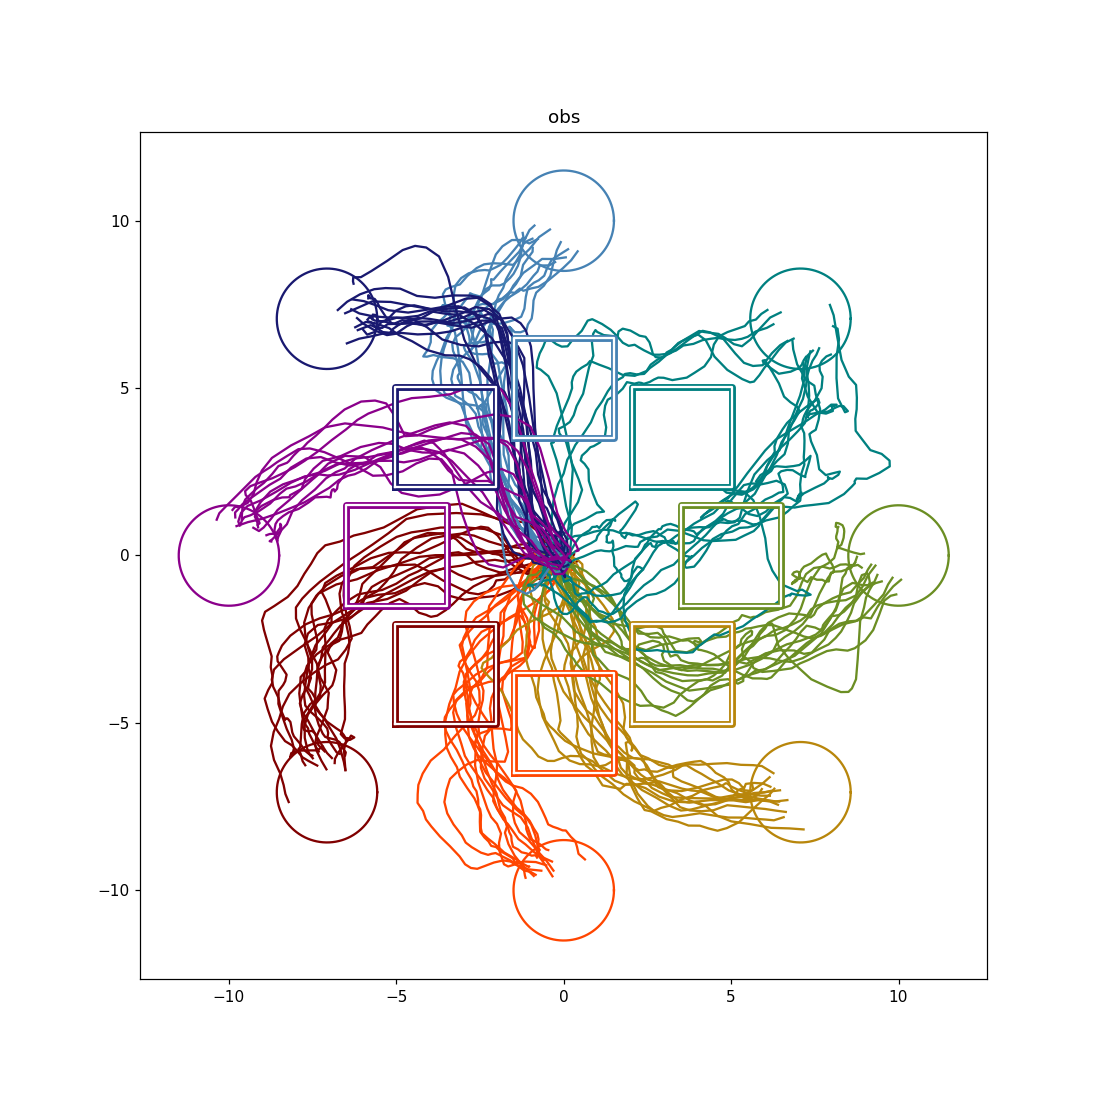

In [9]:
#PLOT INDIVIDUAL TRIALS: 
save_bool = True
plt_prefix = 'trials'
plt_ext = ['.png', '.eps']

plot={}
plot['size'] = (10,10)
plot['xlim'] = (-12.5,12.5)
plot['ylim'] = (-12.5,12.5)

plot_obs_subset = True
plot_obs_small_trials = False
plot_obs_big_trials = True


plot_target = True
plot_obs_small = False
plot_obs_big = True

for task_str in task_list:
    task = task2idx[task_str]
    plt.figure(figsize=plot['size'])
    for target in range(num_targets):
        if task_str == 'co' or (task_str == 'obs' and plot_obs_subset == False): 
            sel = (df['task']==task) & (df['bin']>=0) & (df['target']==target)
        elif task_str == 'obs' and plot_obs_small_trials:
            sel = (df['task']==task) & (df['bin']>=0) & (df['target']==target) & (df['obs_size']==obs_small)
        elif task_str == 'obs' and plot_obs_big_trials:
            sel = (df['task']==task) & (df['bin']>=0) & (df['target']==target) & (df['obs_size']==obs_big)
             
        df_sel = df[sel]
        #------------------------------------------------------------------------------------
        #TRIALS: 
        trial_start = np.where(df_sel['bin']==0)[0]
        trial_stop = np.hstack((trial_start[1:]-1, len(np.where(sel)[0])))
        trial_bound = np.vstack((trial_start,trial_stop)).T
        #------------------------------------------------------------------------------------
        for bnd in trial_bound[:,:]: #trial_bound[0:1,:]:
#             if (task_str == 'co') or (task_str == 'obs') and (df_sel['obs_size'][bnd[0]:bnd[0]+1] == obs_big).bool(): 
            x = df_sel['kin_px'][bnd[0]:bnd[1]+1]
            y = df_sel['kin_py'][bnd[0]:bnd[1]+1]
            color = target_color[target]
            plt.plot(x,y,'-',color=color)

    if plot_obs_small:
        bmi_util.plot_obstacles(obs_pos, target_color, obs_small*np.ones(num_targets))
    if plot_obs_big:
        bmi_util.plot_obstacles(obs_pos, target_color, obs_big*np.ones(num_targets))
    if plot_target: 
        bmi_util.plot_targets(target_pos, target_color, target_r_eff[task]*np.ones(num_targets))  
    
    plt.axis('square')
    plt.title(task_str)
#     plt.xlim(plot['xlim'])
#     plt.ylim(plot['ylim'])
    plt.show()
    
    if save_bool: 
        plt_name = plt_prefix + '_' + task_str
        for ext in plt_ext:
            plt.savefig(os.path.join(save_dir, plt_name+ext))    
    

In [112]:
df.columns

Index([u'n_0', u'n_1', u'n_2', u'n_3', u'n_4', u'n_5', u'n_6', u'n_7', u'n_8',
       u'n_9', u'n_10', u'n_11', u'n_12', u'n_13', u'n_14', u'n_15', u'n_16',
       u'n_17', u'n_18', u'n_19', u'n_20', u'n_21', u'n_22', u'n_23', u'n_24',
       u'n_25', u'n_26', u'n_27', u'n_28', u'n_29', u'n_30', u'n_31', u'n_32',
       u'n_33', u'n_34', u'n_35', u'n_36', u'n_37', u'n_38', u'n_39', u'n_40',
       u'n_41', u'n_42', u'n_43', u'u_px', u'u_py', u'u_vx', u'u_vy',
       u'kin_px', u'kin_py', u'kin_vx', u'kin_vy', u'task', u'tc', u'target',
       u'trial', u'bin', u'trial_start', u'trial_stop', u'target_size',
       u'obs_size'],
      dtype='object')

In [113]:
df.shape

(14718, 61)

In [10]:
#Identify if each trajectory is more clockwise or counterclockwise around the axis from center to target: 

df['cw'] = np.zeros((df.shape[0])) #cw = positive signed area
df['target_axis_signed_area'] = np.zeros((df.shape[0]))
df['target_axis_area'] = np.zeros((df.shape[0]))

trial_start = np.where((df['trial_start']==1))[0]
trial_stop = np.where((df['trial_stop']==1))[0]
trial_bound = np.vstack((trial_start,trial_stop)).T
num_trials = trial_bound.shape[0]

a_dic = {('a','co'):[], ('a','obs'):[], ('sa','co'):[], ('sa','obs'):[]}

for bnd in trial_bound: 
#     print(bnd)
#     x = df.loc[bnd[0]:bnd[1], 'kin_px']
#     y = df.loc[bnd[0]:bnd[1], 'kin_py']
    x = df['kin_px'][bnd[0]:bnd[1]+1]
    y = df['kin_py'][bnd[0]:bnd[1]+1]
    t = int(df['target'][bnd[0]])
    t_pos = target_pos[t,:]
    sa, a, df_a = bmi_b.traj_signed_area_about_target_axis(x, y, t_pos)
    if sa>0:
        cw=1
    else:
        cw=0
    
    #debug: 
    tsk = task_list[int(df['task'][bnd[0]])]
    trl = df['trial'][bnd[0]]
    trl_len = bnd[1]+1-bnd[0]
    print(bnd[0], bnd[1], trl_len, tsk, t, trl, sa, cw, a)
    #Insert the data: 
    df['target_axis_signed_area'][bnd[0]:bnd[1]+1] = sa
    df['cw'][bnd[0]:bnd[1]+1] = cw
    df['target_axis_area'][bnd[0]:bnd[1]+1] = a
    
    #collect for stats: 
    a_dic[('a',tsk)].append(a/trl_len)
    a_dic[('sa',tsk)].append(sa/trl_len)
    

(10, 54, 45, 'co', 0, 12.0, 2.1281241742601202, 1, 2.414440179397094)
(65, 96, 32, 'co', 0, 16.0, -5.764454822835148, 0, 7.068116685350532)
(107, 137, 31, 'co', 0, 24.0, -3.892708659387398, 0, 4.30109238193577)
(148, 169, 22, 'co', 0, 38.0, -3.8760269539053556, 0, 4.423813202685366)
(180, 210, 31, 'co', 0, 46.0, -5.26160142263233, 0, 5.26160142263233)
(221, 252, 32, 'co', 0, 51.0, -4.9471403252063855, 0, 5.055331520905334)
(263, 293, 31, 'co', 0, 56.0, 6.481953721177709, 1, 6.71703823235844)
(304, 349, 46, 'co', 1, 1.0, -5.444897714094759, 0, 8.81043740920863)
(360, 411, 52, 'co', 1, 14.0, 3.079872695967537, 1, 6.023246296083505)
(422, 450, 29, 'co', 1, 21.0, 1.7057096517474548, 1, 1.7444137909390849)
(461, 522, 62, 'co', 1, 31.0, -4.324886797356999, 0, 5.51354777473145)
(533, 574, 42, 'co', 1, 34.0, -9.398350794596556, 0, 10.174426290934015)
(585, 633, 49, 'co', 1, 42.0, -4.5125572970621555, 0, 4.8172095677372635)
(644, 678, 35, 'co', 1, 49.0, -1.1006172043664038, 0, 3.009552996787279

(7276, 7299, 24, 'obs', 6, 6.0, -8.22143543113274, 0, 11.219002012555011)
(7310, 7339, 30, 'obs', 6, 16.0, -19.539991165984592, 0, 19.539991165984592)
(7350, 7371, 22, 'obs', 6, 31.0, -8.018077207262746, 0, 9.294141709371562)
(7382, 7412, 31, 'obs', 6, 32.0, -20.296646863954795, 0, 20.296646863954795)
(7423, 7450, 28, 'obs', 6, 42.0, -17.40038271352312, 0, 17.40038271352312)
(7461, 7487, 27, 'obs', 6, 60.0, -13.172333776560652, 0, 13.188412401513165)
(7498, 7526, 29, 'obs', 6, 61.0, -15.961367227970939, 0, 15.961367227970939)
(7537, 7568, 32, 'obs', 6, 75.0, -16.367600508030378, 0, 17.18997241713867)
(7579, 7609, 31, 'obs', 6, 79.0, -10.60899614727345, 0, 10.616080606768476)
(7620, 7651, 32, 'obs', 6, 83.0, -20.842195279730852, 0, 21.223819925822127)
(7662, 7695, 34, 'obs', 6, 85.0, -11.455887426528315, 0, 11.923308154212295)
(7706, 7733, 28, 'obs', 7, 3.0, -14.355217317277663, 0, 14.421032863617762)
(7744, 7771, 28, 'obs', 7, 14.0, -21.383278208028692, 0, 21.7137389693713)
(7782, 7815

<IPython.core.display.Javascript object>


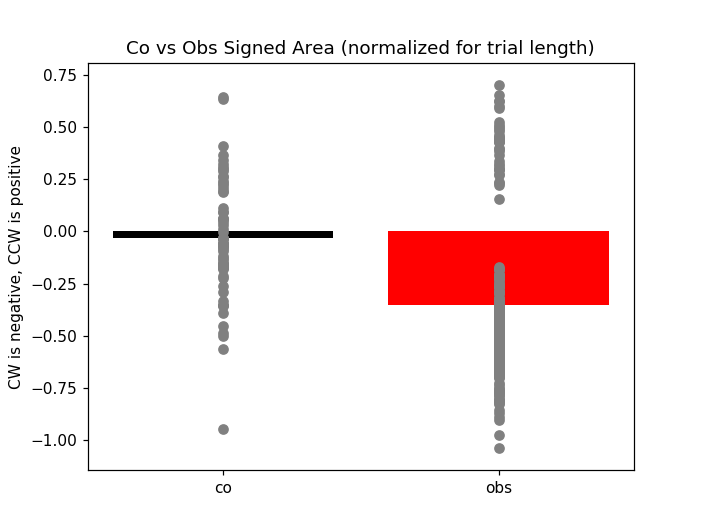

<IPython.core.display.Javascript object>


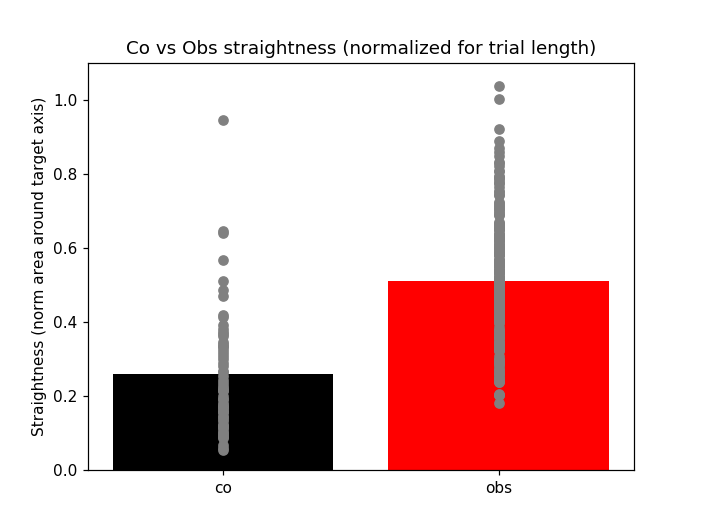

([<matplotlib.axis.XTick at 0x4566a0c8>,
 <a list of 2 Text xticklabel objects>)

In [11]:
#SIGNED AREA: 

color=0.5*np.ones(3)

#cw vs ccw
a_co = np.array(a_dic['sa','co'])
a_obs = np.array(a_dic['sa','obs'])
plt.figure()
plt.bar(0,np.mean(a_co), color='k')
plt.bar(1,np.mean(a_obs), color='r')
plt.scatter(np.zeros(len(a_co)), a_co, color=color, zorder=10000)
plt.scatter(np.ones(len(a_obs)), a_obs, color=color, zorder=10000)
plt.title('Co vs Obs Signed Area (normalized for trial length)')
plt.ylabel('CW is negative, CCW is positive')
plt.xticks((0,1), ('co', 'obs'))

#UNSIGNED AREA: 
a_co = np.array(a_dic['a','co'])
a_obs = np.array(a_dic['a','obs'])
plt.figure()
plt.bar(0,np.mean(a_co), color='k')
plt.bar(1,np.mean(a_obs), color='r')
plt.scatter(np.zeros(len(a_co)), a_co, color=color, zorder=10000)
plt.scatter(np.ones(len(a_obs)), a_obs, color=color, zorder=10000)
plt.title('Co vs Obs straightness (normalized for trial length)')
plt.ylabel('Straightness (norm area around target axis)')
plt.xticks((0,1), ('co', 'obs'))

In [12]:
# 1) Convert stuff to polar, 2) center angles at target angle, 3) calculate distance to target
# 1) Convert stuff to polar
df['p_mag'], df['p_angle'] = bmi_b.cartesian2polar(df['kin_py'], df['kin_px'])
df['v_mag'], df['v_angle'] = bmi_b.cartesian2polar(df['kin_vy'], df['kin_vx'])
df['u_p_mag'], df['u_p_angle'] = bmi_b.cartesian2polar(df['u_py'], df['u_px'])
df['u_v_mag'], df['u_v_angle'] = bmi_b.cartesian2polar(df['u_vy'], df['u_vx'])
# 2) Center @ target angle: 
d_list = ['p_angle', 'v_angle', 'u_p_angle', 'u_v_angle']
for d in d_list:
    data = df[d]
    zeros = np.zeros(data.shape)
    t_angle = target_angle[df['target'].astype(int)]
    df[d+'_ctr'] = bmi_b.center_angle(df[d], zeros, t_angle)
# 3) distance to target
error = df.loc[:, 'kin_px':'kin_py']-target_pos[df['target'].astype(int),:]
df['d2target'] = np.linalg.norm(error,ord=2,axis=1)
df['x_error'] = error.loc[:,'kin_px']
df['y_error'] = error.loc[:,'kin_py']


In [13]:
df.loc[0:55, ['target','bin', 'trial_start', 'trial_stop', 'd2target']]

target   bin  trial_start  trial_stop   d2target
0      0.0 -10.0          0.0         0.0  18.560671
1      0.0  -9.0          0.0         0.0  18.844048
2      0.0  -8.0          0.0         0.0  19.180040
3      0.0  -7.0          0.0         0.0  19.319563
4      0.0  -6.0          0.0         0.0  19.482174
5      0.0  -5.0          0.0         0.0  19.487144
6      0.0  -4.0          0.0         0.0  19.347643
7      0.0  -3.0          0.0         0.0   9.780188
8      0.0  -2.0          0.0         0.0   9.778908
9      0.0  -1.0          0.0         0.0   9.636667
10     0.0   0.0          1.0         0.0   9.463396
11     0.0   1.0          0.0         0.0   9.331970
12     0.0   2.0          0.0         0.0   9.078341
13     0.0   3.0          0.0         0.0   8.757569
14     0.0   4.0          0.0         0.0   8.383691
15     0.0   5.0          0.0         0.0   7.936010
16     0.0   6.0          0.0         0.0   7.608077
17     0.0   7.0          0.0         0.0   7.227405
18     0.0   8.0          0.0         0.0   6.762120
19     0.0   9.0          0.0         0.0   6.327757
20     0.0  10.0          0.0         0.0   5.876916
21     0.0  11.0          0.0         0.0   5.571757
22     0.0  12.0          0.0         0.0   5.270490
23     0.0  13.0          0.0         0.0   4.973313
24     0.0  14.0          0.0         0.0   4.625216
25     0.0  15.0          0.0         0.0   4.435875
26     0.0  16.0          0.0         0.0   4.219515
27     0.0  17.0          0.0         0.0   4.066731
28     0.0  18.0          0.0         0.0   3.949040
29     0.0  19.0          0.0         0.0   3.737440
30     0.0  20.0          0.0         0.0   3.428611
31     0.0  21.0          0.0         0.0   2.990633
32     0.0  22.0          0.0         0.0   2.662363
33     0.0  23.0          0.0         0.0   2.388489
34     0.0  24.0          0.0         0.0   2.177936
35     0.0  25.0          0.0         0.0   2.044380
36     0.0  26.0          0.0         0.0   1.814991
37     0.0  27.0          0.0         0.0   1.687016
38     0.0  28.0          0.0         0.0   1.571461
39     0.0  29.0          0.0         0.0   1.426684
40     0.0  30.0          0.0         0.0   1.377756
41     0.0  31.0          0.0         0.0   1.327379
42     0.0  32.0          0.0         0.0   1.389337
43     0.0  33.0          0.0         0.0   1.436565
44     0.0  34.0          0.0         0.0   1.505731
45     0.0  35.0          0.0         0.0   1.700288
46     0.0  36.0          0.0         0.0   1.801253
47     0.0  37.0          0.0         0.0   1.718691
48     0.0  38.0          0.0         0.0   1.551812
49     0.0  39.0          0.0         0.0   1.416269
50     0.0  40.0          0.0         0.0   1.353146
51     0.0  41.0          0.0         0.0   1.328749
52     0.0  42.0          0.0         0.0   1.245103
53     0.0  43.0          0.0         0.0   1.211472
54     0.0  44.0          0.0         1.0   1.146614
55     0.0 -10.0          0.0         0.0   7.864205

In [17]:
#Sanity: 
#Check number of trials for cw ccw obstacle: 
obs_cond_list = [('obs', 0), ('obs', 1)]
obs_num_trials = {('obs', 0):np.zeros(num_targets), ('obs', 1):np.zeros(num_targets)}
for cond in obs_cond_list:
    task = task2idx[cond[0]]
    cw = cond[1]
    
    for target in range(num_targets):
        #------------------------------------------------------------------------------------
        #TRIALS:     
        trial_start = np.where((df['trial_start']==1) & (df['target']==target) & (df['task']==task) & (df['cw']==cw))[0]
        trial_stop = np.where((df['trial_stop']==1) & (df['target']==target) & (df['task']==task) & (df['cw']==cw))[0]
        trial_bound = np.vstack((trial_start,trial_stop)).T
        num_trials = trial_bound.shape[0]
        #------------------------------------------------------------------------------------        
        obs_num_trials[cond][target] = num_trials
        


In [18]:
print(obs_num_trials[('obs',0)])
print(obs_num_trials[('obs',1)])

[28. 28. 30. 28. 17.  0. 27. 27.]
[ 0.  0.  0.  0. 11. 26.  0.  0.]


In [19]:
#INTERPOLATED PSTH
task_cond_list = [('co','all'), ('obs',0), ('obs', 1)]
#(1.7 - 0.4 = 1.3 for CO, and 2.0 - 0.5 = 1.5 for OBS).
target_r_eff = {0:1.3, 1:1.5}

num_var = df.shape[1]
num_interp_pts = 100
time_win = np.array([0, num_interp_pts])
num_time = np.diff(time_win)[0]
da_dic = {}

for task_cond in task_cond_list:
    task = task2idx[task_cond[0]]
    cw = task_cond[1]
    for target in range(num_targets):
        #------------------------------------------------------------------------------------
        #TRIALS: 
        if cw == 'all':
            trial_start = np.where((df['trial_start']==1) & (df['target']==target) & (df['task']==task))[0]
            trial_stop = np.where((df['trial_stop']==1) & (df['target']==target) & (df['task']==task))[0]
            trial_bound = np.vstack((trial_start,trial_stop)).T
            num_trials = trial_bound.shape[0]
        else:
            trial_start = np.where((df['trial_start']==1) & (df['target']==target) & (df['task']==task) & (df['cw']==cw))[0]
            trial_stop = np.where((df['trial_stop']==1) & (df['target']==target) & (df['task']==task) & (df['cw']==cw))[0]
            trial_bound = np.vstack((trial_start,trial_stop)).T
            num_trials = trial_bound.shape[0]
        #------------------------------------------------------------------------------------        
        #Initialize a nan-filled xarray
        nan_mat = np.ones((num_var, num_time, num_trials))*np.nan
        da = xr.DataArray(nan_mat,
                    coords={'var':list(df.columns),
                                     'time':range(num_time),
                                     'trial':range(num_trials)},
                    dims=['var','time','trial'])
        for trial, bnd in enumerate(trial_bound): #trial_bound[0:1,:]:
            d2target = df.loc[bnd[0]:bnd[1],'d2target']
            end = bnd[0]+np.where(d2target <= target_r_eff[task])[0][0]
            trial_len = end-bnd[0]+1
            #Linearly interpolate the trial: 
            d_trial = np.array(df.loc[bnd[0]:end,:])
            x = np.arange(0,trial_len)
            f = scipy.interpolate.interp1d(x,d_trial,axis=0)
            x_interp = np.linspace(x[0],x[-1],num_interp_pts)
            d_interp = f(x_interp).T
            da[:,:,trial] = d_interp
        da_dic[(task_cond,target)] = da

In [20]:
#Number of trials in the xarray
da_dic[('obs',0), 5].coords['trial'].shape[0]

0

In [21]:
#CALCULATE PSTH:
psth_dic = {}
for task_cond in task_cond_list:
    for target in range(num_targets):
        mean = da_dic[task_cond,target].mean(axis=2,skipna=True)
        N = da_dic[task_cond,target].coords['trial'].shape[0]
        #np.logical_not(np.isnan(da_dic[task_cond,target])).sum(axis=2) #number of data points per sample
        var = da_dic[task_cond,target].var(axis=2,skipna=True)
        sem = (var/N)**(0.5)
        
        psth_dic[task_cond,target,'mean'] = mean
        psth_dic[task_cond,target,'N'] = N
        psth_dic[task_cond,target,'var'] = var
        psth_dic[task_cond,target,'sem'] = sem

c:\anaconda3\envs\py2\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
c:\anaconda3\envs\py2\lib\site-packages\xarray\core\nputils.py:222: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwds)


In [22]:
psth_dic[('obs',0),5,'N']

0

<IPython.core.display.Javascript object>


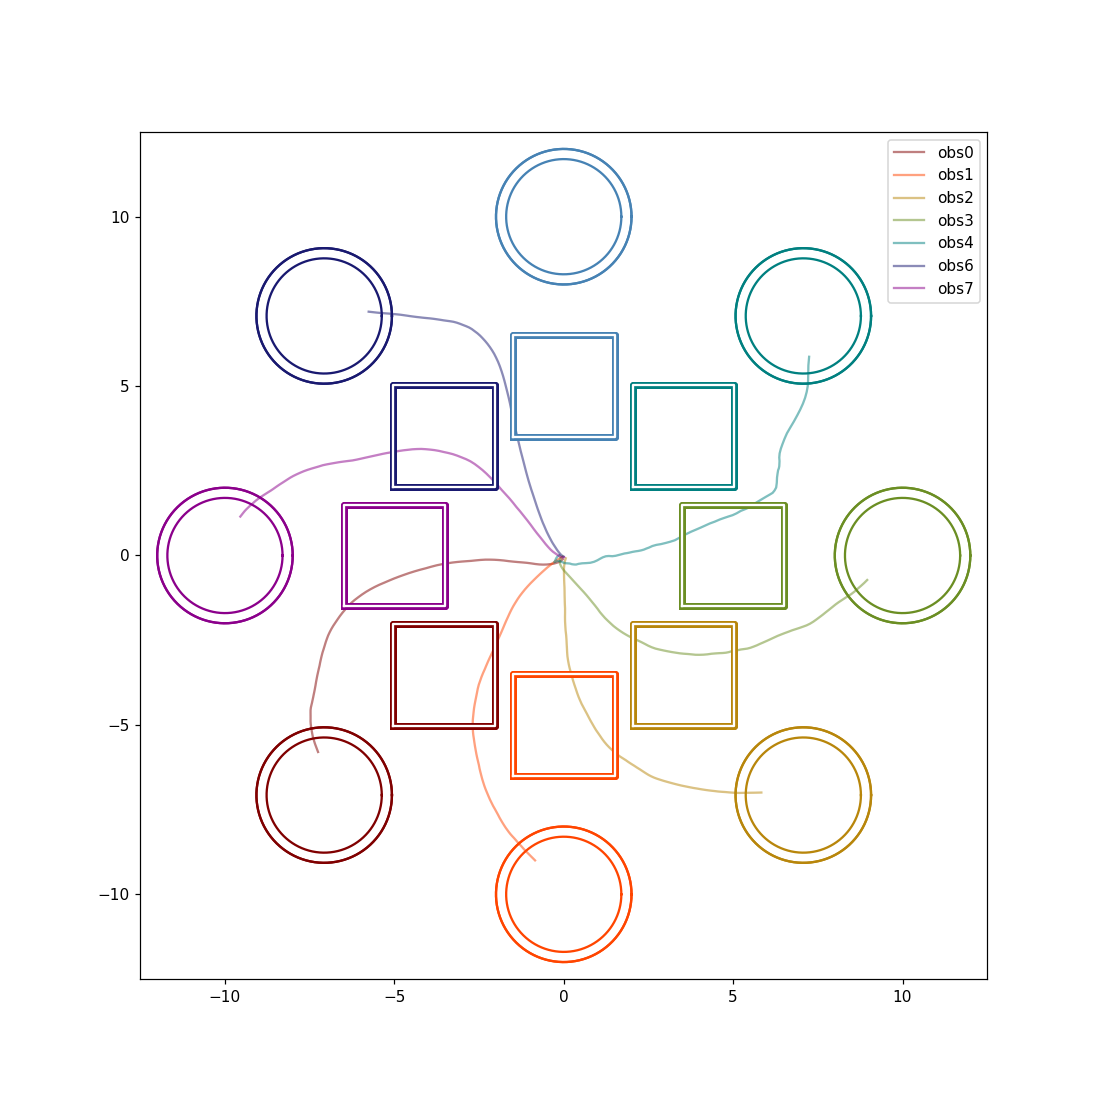

In [53]:
#PLOT PSTH
plt_prefix = 'psth_p_traj'
plt_ext = ['.png', '.eps']

plt_len = 100

save_bool = False

plt.figure(figsize=plot['size'])
for task_cond in task_cond_list:
    task_str = task_cond[0]
    task = task2idx[task_str]
    cw = task_cond[1]
    
    for target in range(num_targets):
        data = psth_dic[task_cond,target,'mean']
        count = psth_dic[task_cond,target,'N']
        
        if (count > 0):# and (task_str == 'obs') and (not cw):
            x = data.loc['kin_px'][:plt_len] #num_time X num_trials
            y = data.loc['kin_py'][:plt_len]
            color = target_color[target]
            plt.plot(x, y, '-', color=color, alpha=1-task*0.5, label=task_str + str(target))
            
    if plot_obs_small:
        bmi_util.plot_obstacles(obs_pos, target_color, obs_small*np.ones(num_targets))
    if plot_obs_big:
        bmi_util.plot_obstacles(obs_pos, target_color, obs_big*np.ones(num_targets))
    if plot_target: 
        bmi_util.plot_targets(target_pos, target_color, target_r_task[task]*np.ones(num_targets))  
    
    plt.axis('square')
    plt.legend()
#     plt.title(task_str)
    plt.xlim(plot['xlim'])
    plt.ylim(plot['ylim'])
    plt.show()
    
    #---------------------------------------------------------------------------------------------
    if save_bool:
        plt_name = plt_prefix + '_' + idx2task[task]
        for ext in plt_ext:
            plt.savefig(os.path.join(save_dir, plt_name+ext))    

In [24]:
#Per task, all conditions together: 
run_bool = False

if run_bool:
    plot_data = ['kin_px', 'kin_py']
    for d in plot_data:
        for task_cond in task_cond_list: #[('obs', 'cw')]:
            task = task_cond[0]
            plt.figure(figsize=(10,10))
            for target in range(num_targets):
                t = psth_dic[task_cond,target,'mean']['time']
                x = psth_dic[task_cond,target,'mean'].loc[d]
                x_sem = psth_dic[task_cond,target,'sem'].loc[d]

                #Plot: 
                plt.plot(t,x,'.-', color=target_color[target])
                plt.fill_between(t, x-x_sem,x+x_sem,alpha=0.5,color=target_color[target])
            plt.legend()
            plt.title(d + ' task, cond: ' + str(task_cond))
            plt.xlabel('time (s)')
    #         plt.xlim([0, 8])
            plt.ylim([-12,12])

In [221]:
task_cond_list

[('co', 'all'), ('obs', 0), ('obs', 1)]

<IPython.core.display.Javascript object>


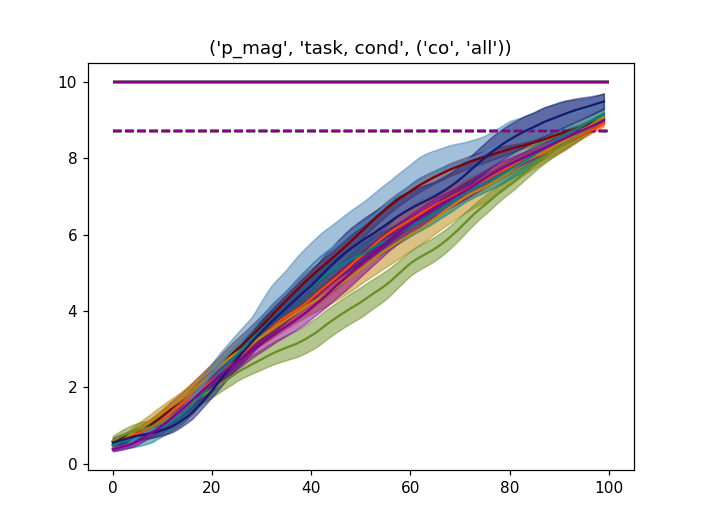

<IPython.core.display.Javascript object>


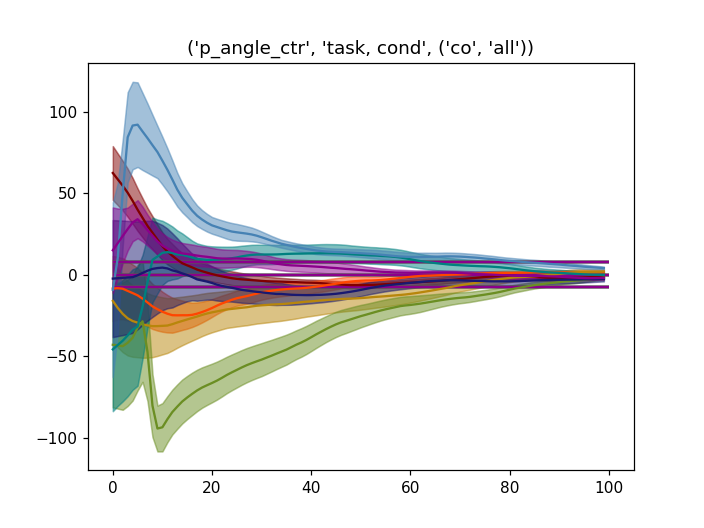

<IPython.core.display.Javascript object>


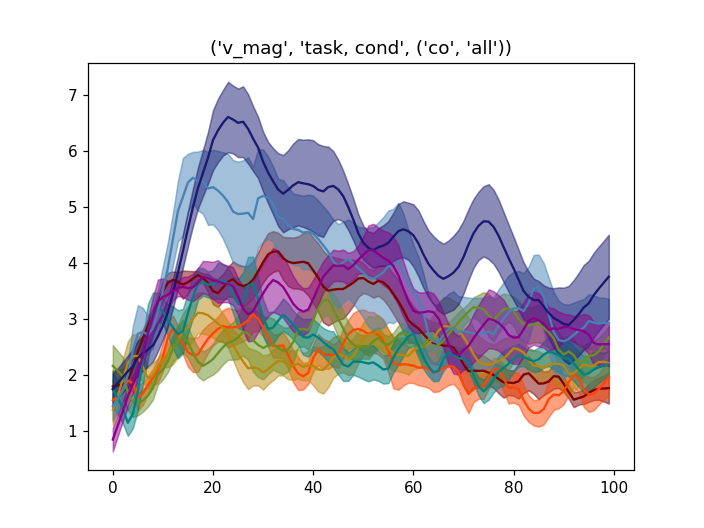

<IPython.core.display.Javascript object>


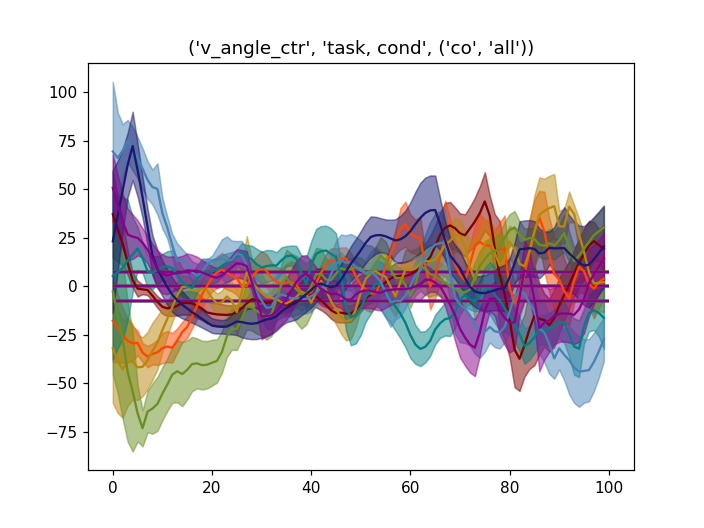

<IPython.core.display.Javascript object>


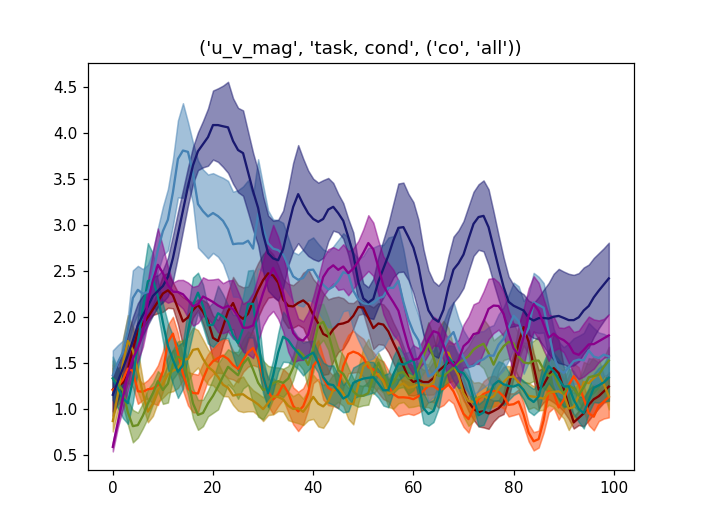

<IPython.core.display.Javascript object>


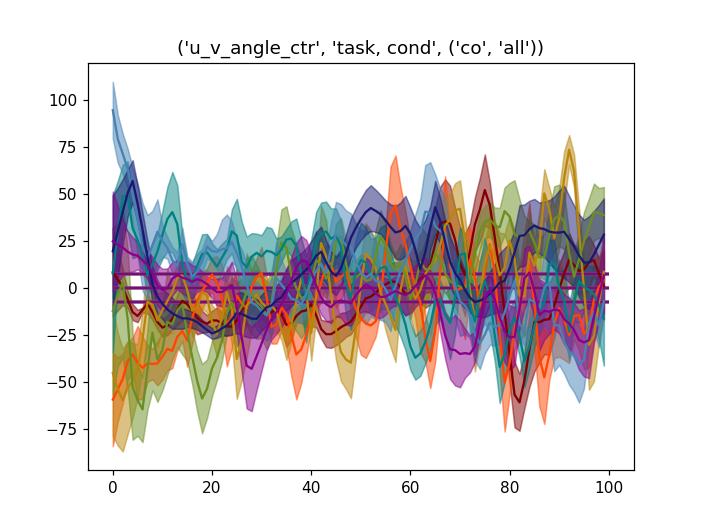

<IPython.core.display.Javascript object>


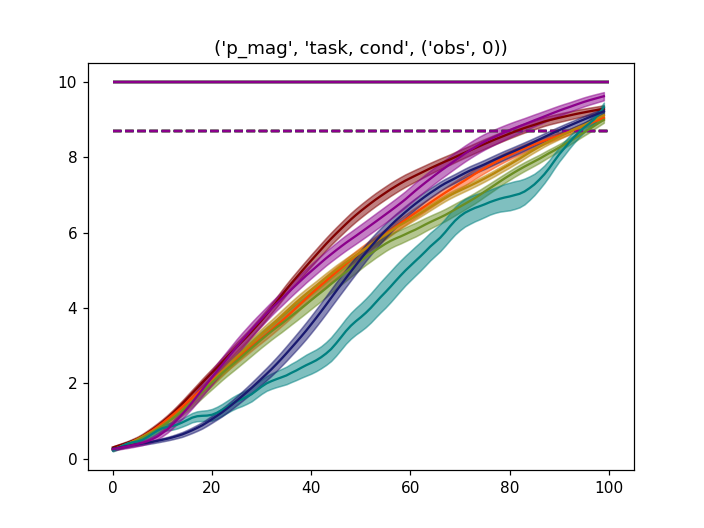

<IPython.core.display.Javascript object>


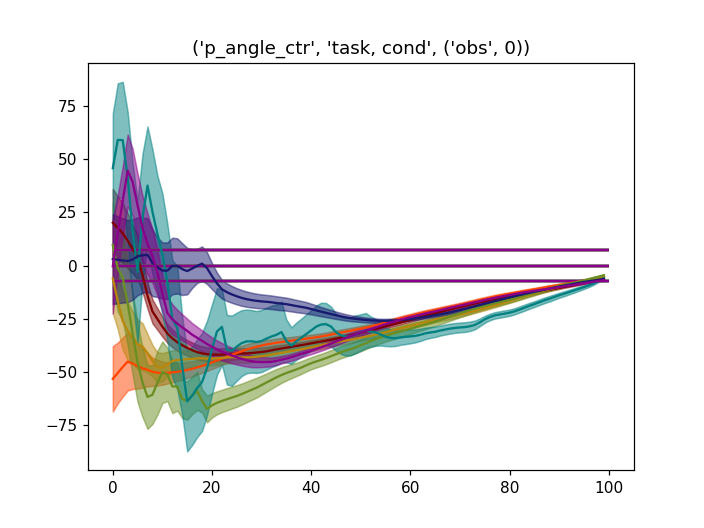

<IPython.core.display.Javascript object>


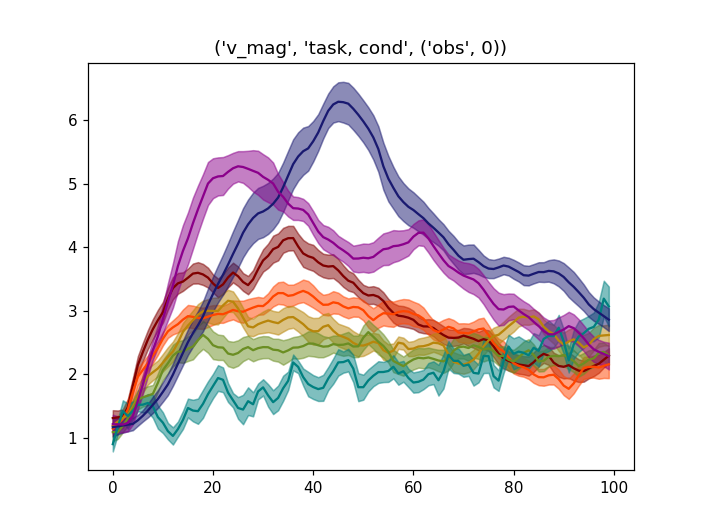

<IPython.core.display.Javascript object>


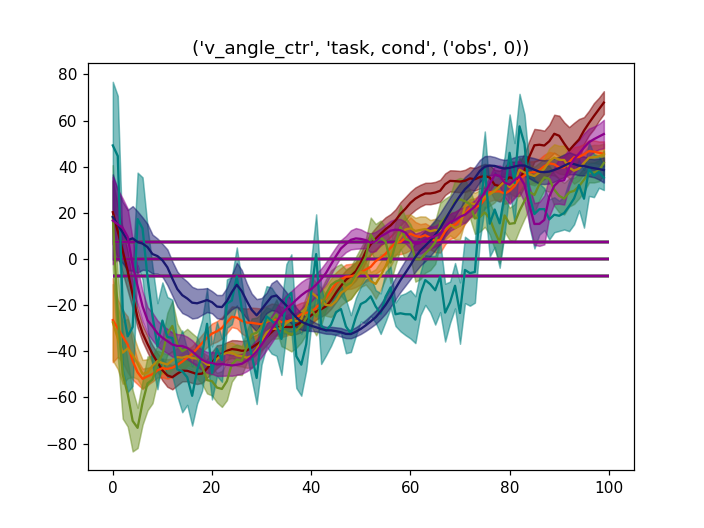

<IPython.core.display.Javascript object>


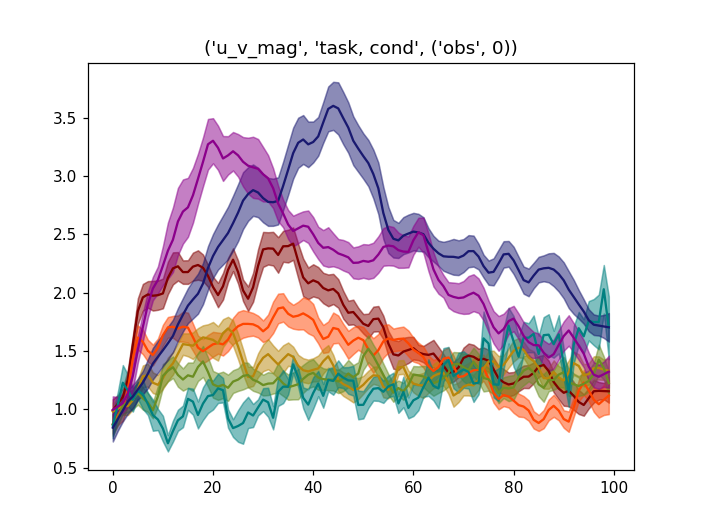

<IPython.core.display.Javascript object>


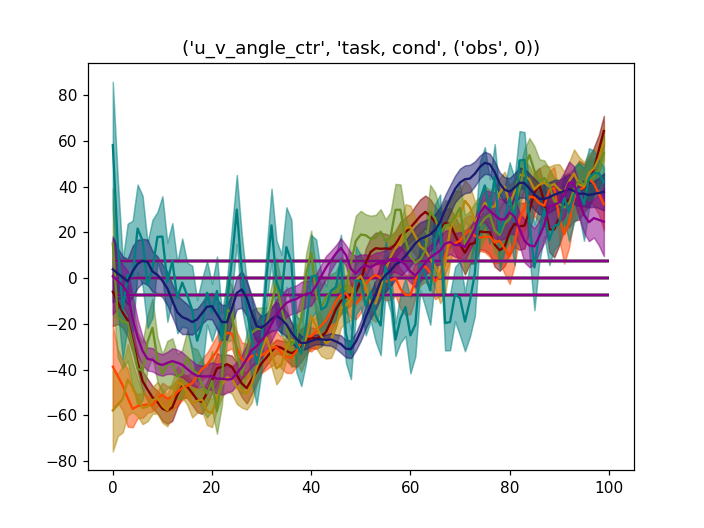

c:\anaconda3\envs\py2\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


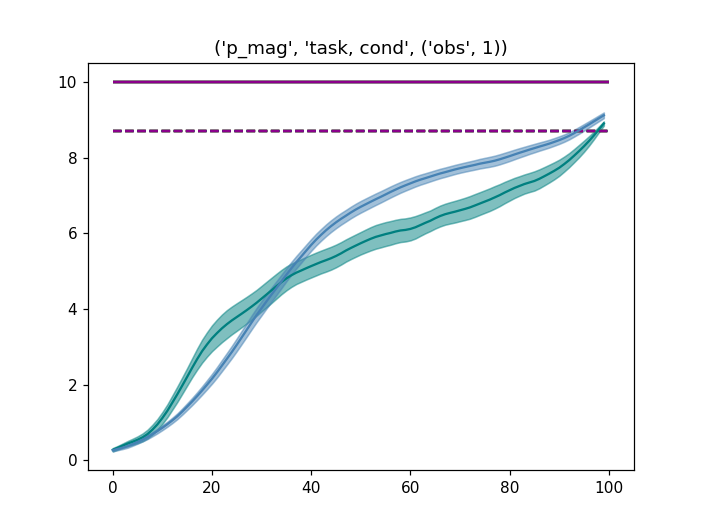

<IPython.core.display.Javascript object>


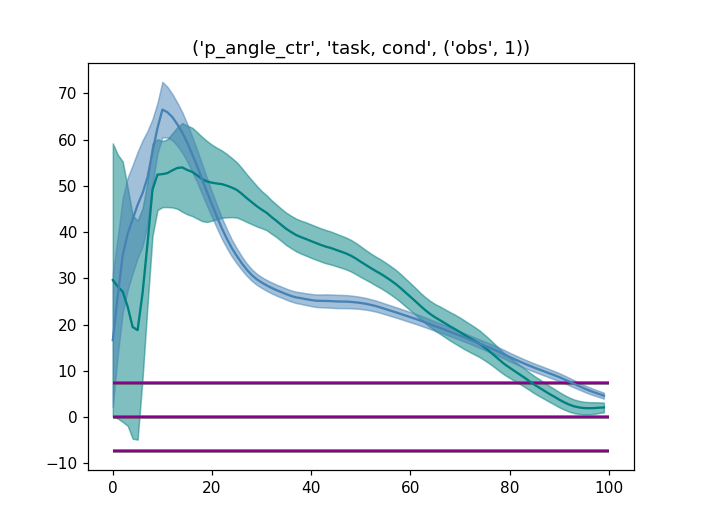

<IPython.core.display.Javascript object>


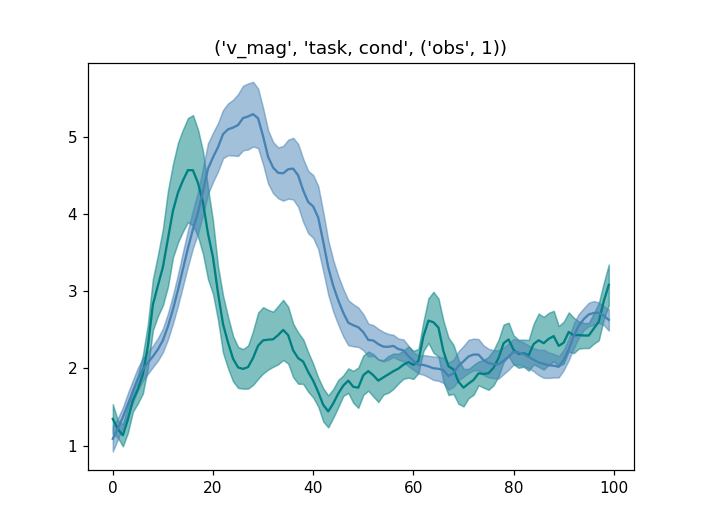

<IPython.core.display.Javascript object>


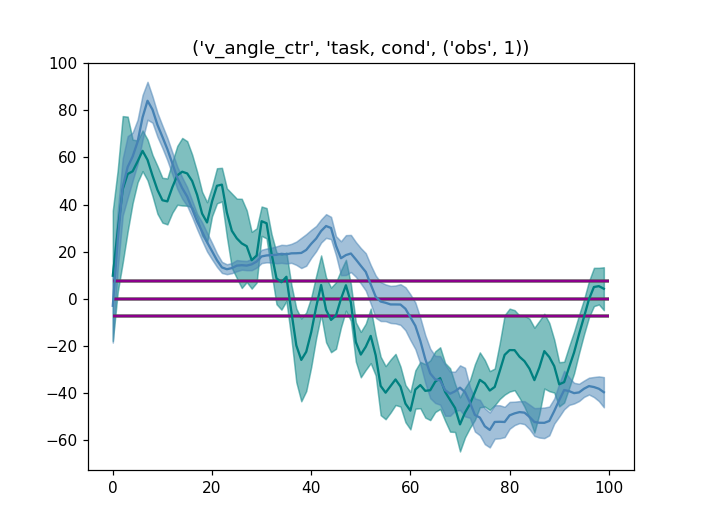

<IPython.core.display.Javascript object>


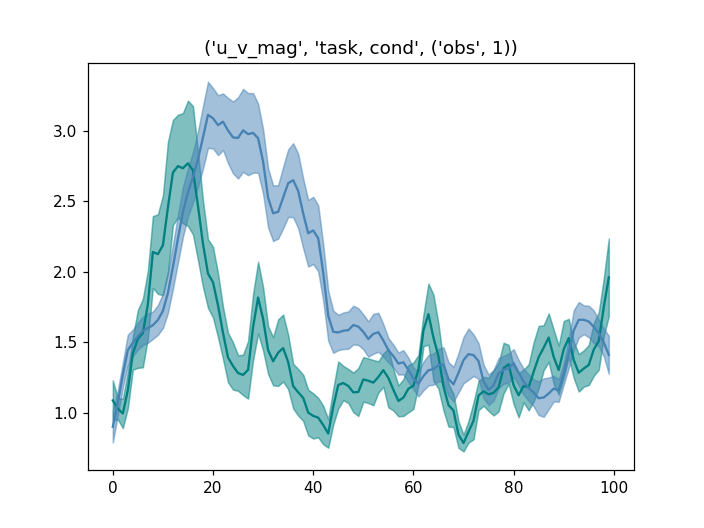

<IPython.core.display.Javascript object>


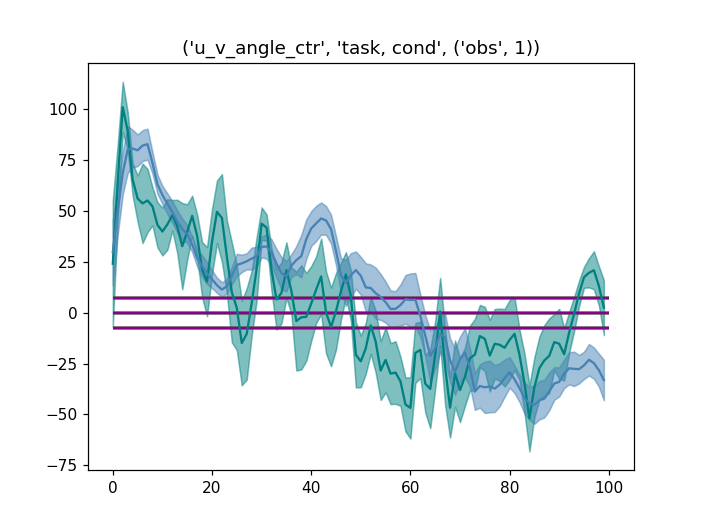

In [25]:
#ALL TARGETS TOGETHER, task separate
ctrl_list = ['p_mag', 'p_angle_ctr', 'v_mag', 'v_angle_ctr', 'u_v_mag', 'u_v_angle_ctr'] #'u_p_mag', 'u_p_angle',
task = 0
# target = 0
plt_len=100

save_bool = False
plt_prefix = 'psth'
plt_ext = ['.png', '.eps']

for task_cond in task_cond_list:
    task = task_cond[0]
    for d in ctrl_list: 
        plt.figure()
        for target in range(num_targets):

            t = psth_dic[task_cond,target,'mean']['time']
            y_mean = psth_dic[task_cond,target,'mean'].loc[d]
            y_sem = psth_dic[task_cond,target,'sem'].loc[d]            
            
            if 'angle_ctr' in d:
#                 y = y*180/np.pi
                y_mean = y_mean*180/np.pi
                y_sem = y_sem*180/np.pi 
                plt.hlines(0,0,plt_len,color=target_color[target])
                plt.hlines(-theta_max*180/np.pi,0,plt_len,color=target_color[target])
                plt.hlines(theta_max*180/np.pi,0,plt_len,color=target_color[target])
            elif 'angle_' in d:
#                 y = y*180/np.pi
                y_mean = y_mean*180/np.pi
                y_sem = y_sem*180/np.pi 
                plt.hlines(target_angle[target]*180/np.pi,0,plt_len,color=target_color[target])
            elif d == 'p_mag':
                plt.hlines(target_dist[target],0,plt_len,color=target_color[target])
                plt.hlines(target_dist[target]-target_r_eff[0],0,plt_len, linestyles='--', color=target_color[target])
                
            plt.plot(y_mean, color=target_color[target])
            plt.fill_between(range(len(y_mean)), y_mean-y_sem,y_mean+y_sem,alpha=0.5,color=target_color[target])
        plt.title((d, 'task, cond', task_cond))
        
        if save_bool: 
            plt_name = plt_prefix + '_' + task + '_' + d
            for ext in plt_ext:
                plt.savefig(os.path.join(save_dir, plt_name+ext))
        

### Average over targets and compare task: 

In [27]:
psth_dic[('obs',0),5,'N']

0

In [48]:
#Aggregate psth data 

#Initialize data: 
ctrl_psth = {}
d_list = ['p_mag', 'p_angle_ctr', 'v_mag', 'v_angle_ctr', 'u_v_mag', 'u_v_angle_ctr']
for task in range(num_tasks):
    for d in d_list:
        ctrl_psth[task,d,'mat'] = []
        ctrl_psth[task,d,'target'] = [] #save the target of each saved psth
        ctrl_psth[task,d,'cw'] = [] #save the cw of each saved psth
        ctrl_psth[task,d,'N'] = [] #save the cw of each saved psth

#Aggregate:  
#For obstacle task, orient the angles to be positive:
#

min_N = 0
for d in d_list: 
    for task_cond in task_cond_list:
        task_str = task_cond[0]
        task = task2idx[task_str]
        cw = task_cond[1]
        
        for target in range(num_targets):
            N = psth_dic[task_cond,target,'N']
            if N > min_N:
                mean = psth_dic[task_cond,target,'mean'].loc[d]
                mean = np.array(mean)
                if (task_str == 'obs') & ('angle' in d) & (not cw):
                    mean = -mean
                ctrl_psth[task,d,'mat'].append(mean)
                ctrl_psth[task,d,'target'].append(target)
                ctrl_psth[task,d,'cw'].append(cw)
                ctrl_psth[task,d,'N'].append(N)

#Convert to np array: 
for task in range(num_tasks):
    for d in d_list: 
        ctrl_psth[task,d,'target'] = np.array(ctrl_psth[task,d,'target'])
        
        d_mat = np.array(ctrl_psth[task,d,'mat'])
        ctrl_psth[task,d,'mat'] = d_mat
        ctrl_psth[task,d,'mean'] = d_mat.mean(axis=0)
        ctrl_psth[task,d,'var'] = d_mat.var(axis=0)
        ctrl_psth[task,d,'sem'] = sio_stat.sem(d_mat, axis=0, nan_policy='omit')

In [51]:
for task in range(num_tasks):
    print(ctrl_psth[task,'u_v_angle_ctr','target'])
    print(ctrl_psth[task,'u_v_angle_ctr','cw'])
    print(ctrl_psth[task,'u_v_angle_ctr','N'])

[0 1 2 3 4 5 6 7]
['all', 'all', 'all', 'all', 'all', 'all', 'all', 'all']
[7, 8, 8, 8, 8, 8, 8, 8]
[0 1 2 3 4 6 7 4 5]
[0, 0, 0, 0, 0, 0, 0, 1, 1]
[28, 28, 30, 28, 17, 27, 27, 11, 26]


<IPython.core.display.Javascript object>


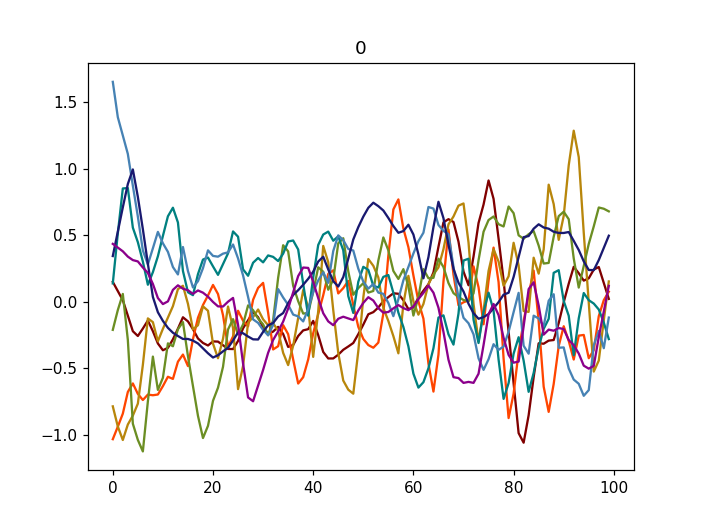

<IPython.core.display.Javascript object>


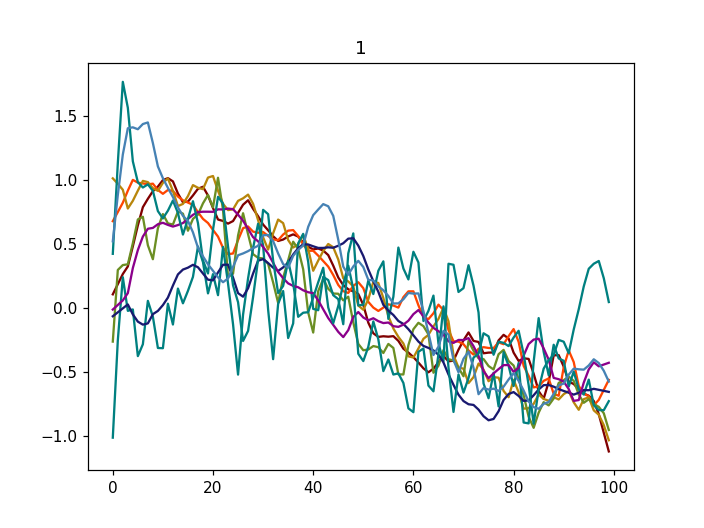

In [50]:
d_list = ['u_v_angle_ctr'] #'u_v_mag'
for task in range(num_tasks):
    plt.figure()
    for d in d_list:
        y_mat = ctrl_psth[task,d,'mat']
        for i,target in enumerate(ctrl_psth[task,d,'target']):
            plt.plot(y_mat[i,:], color=target_color[target])
    plt.title(task)

<IPython.core.display.Javascript object>


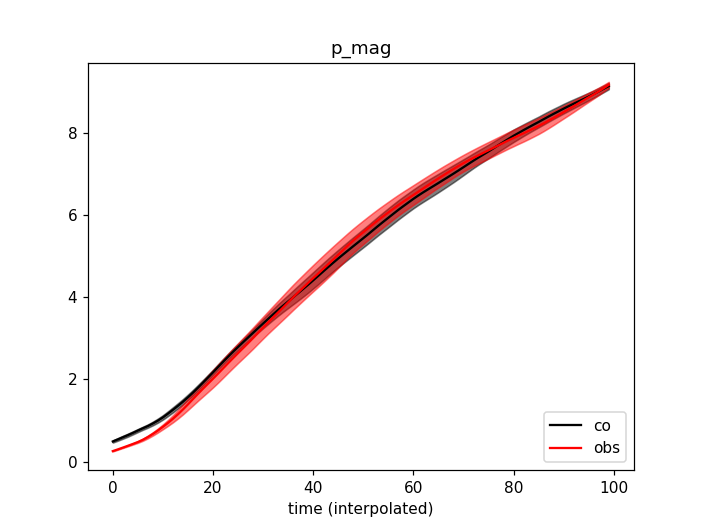

<IPython.core.display.Javascript object>


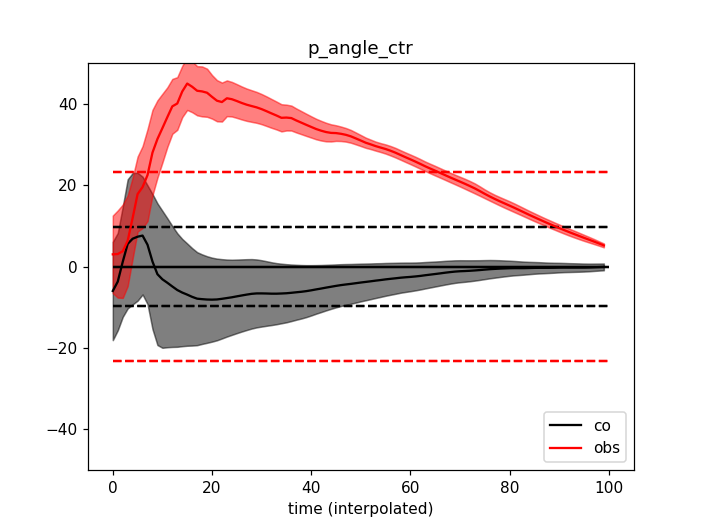

<IPython.core.display.Javascript object>


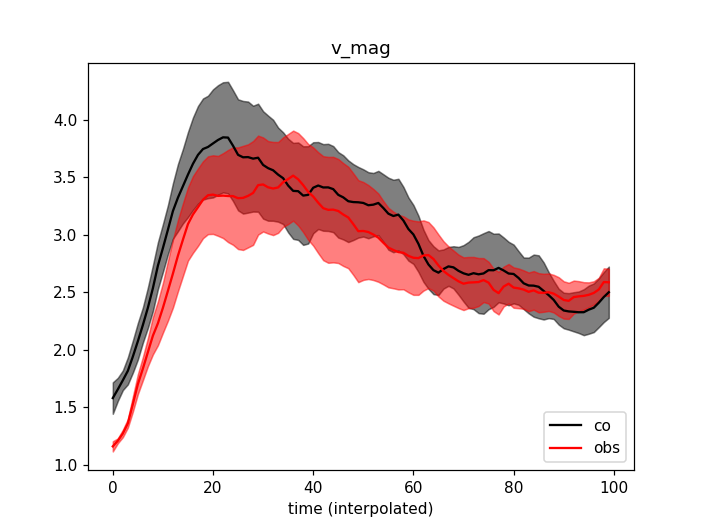

<IPython.core.display.Javascript object>


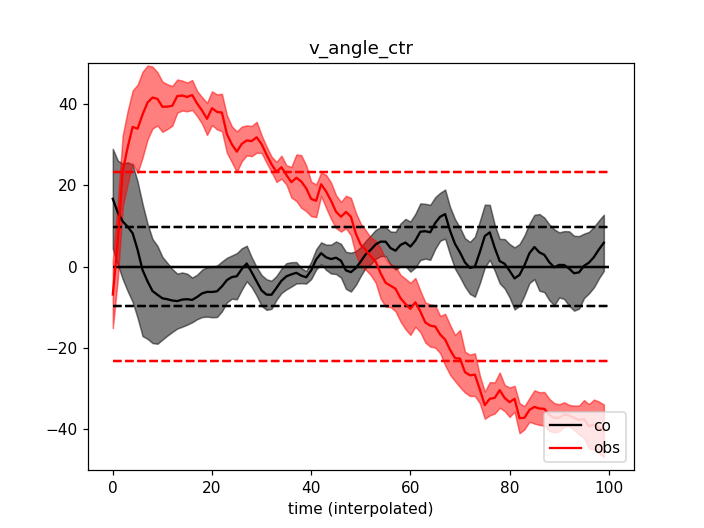

<IPython.core.display.Javascript object>


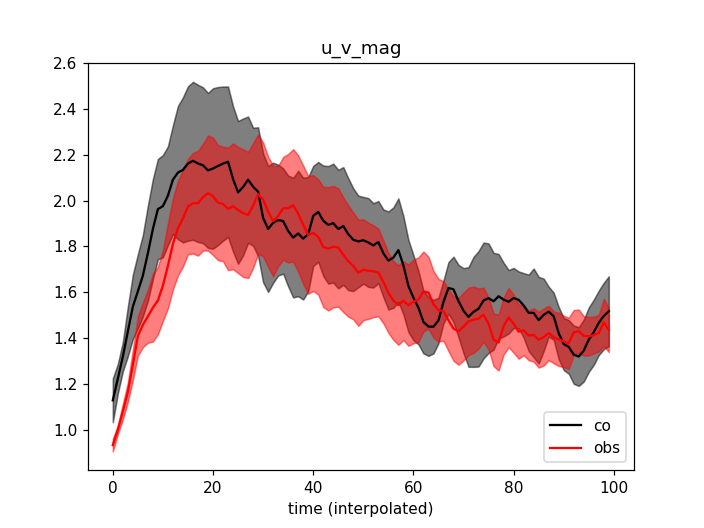

<IPython.core.display.Javascript object>


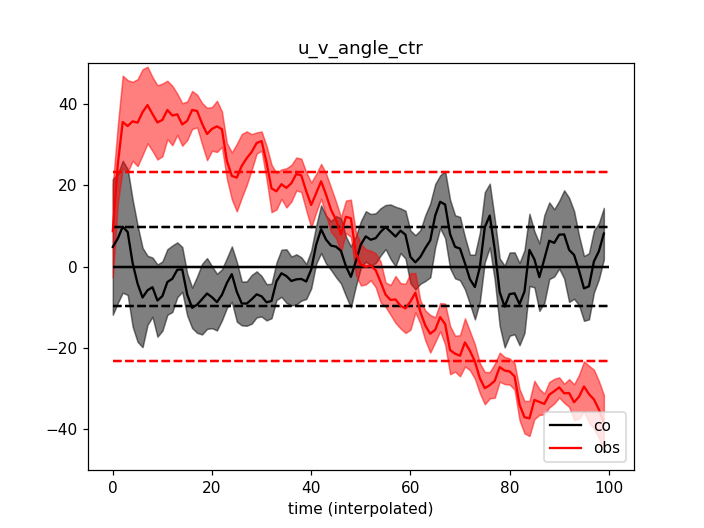

In [147]:
save_bool = True
plt_prefix = 'task_psth'
plt_ext = ['.png', '.eps']

d_list = ['p_mag', 'p_angle_ctr', 'v_mag', 'v_angle_ctr', 'u_v_mag', 'u_v_angle_ctr']
plot_len = 100
for d in d_list:
    plt.figure()
    for task in range(num_tasks):
        y_mean = ctrl_psth[task,d,'mean'][:plot_len]
        y_sem = ctrl_psth[task,d,'sem'][:plot_len]
        if 'angle' in d:
            y = y*180/np.pi
            y_mean = y_mean*180/np.pi
            y_sem = y_sem*180/np.pi 
            plt.hlines(0,0,plot_len,color='k')
            plt.hlines(theta_max*180/np.pi,0,plot_len,color='k',linestyles='dashed')
            plt.hlines(-theta_max*180/np.pi,0,plot_len,color='k',linestyles='dashed')
            
            plt.hlines(obs_theta*180/np.pi,0,plot_len,color='r',linestyles='dashed')
            plt.hlines(-obs_theta*180/np.pi,0,plot_len,color='r',linestyles='dashed')            
            
            plt.legend()
        plt.plot(y_mean, color=task_color[task],label=idx2task[task])
        plt.fill_between(range(len(y_mean)), y_mean-y_sem,y_mean+y_sem,alpha=0.5,color=task_color[task])
    plt.xlabel('time (interpolated)')
    plt.title(d)
    plt.legend(loc = 'lower right')
    if 'angle' in d:
        plt.ylim(-50,50)
#         plt.axis('square')
    
        
    if save_bool: 
        plt_name = plt_prefix + '_' + d
        for ext in plt_ext:
            plt.savefig(os.path.join(save_dir, plt_name+ext))

### Position PSTH: Average over targets and compare task: 

In [55]:
target_pos

array([[-7.07106781e+00, -7.07106781e+00],
       [-1.83697020e-15, -1.00000000e+01],
       [ 7.07106781e+00, -7.07106781e+00],
       [ 1.00000000e+01,  0.00000000e+00],
       [ 7.07106781e+00,  7.07106781e+00],
       [ 6.12323400e-16,  1.00000000e+01],
       [-7.07106781e+00,  7.07106781e+00],
       [-1.00000000e+01,  1.22464680e-15]])

In [ ]:
#Rotate each psth by target angle: 
#Negate based on cw 

for target in range(num_targets): 
    t_pos = target_pos[target,:]
    t_theta = np.arctan2(t_pos[1],t_pos[0])
    t_rot_mat = bmi_b.rot2D_mat(-t_theta)
    
    


In [57]:
x.shape

(100L,)

In [62]:
obs_pos

array([[-3.53553391e+00, -3.53553391e+00],
       [-9.18485099e-16, -5.00000000e+00],
       [ 3.53553391e+00, -3.53553391e+00],
       [ 5.00000000e+00,  0.00000000e+00],
       [ 3.53553391e+00,  3.53553391e+00],
       [ 3.06161700e-16,  5.00000000e+00],
       [-3.53553391e+00,  3.53553391e+00],
       [-5.00000000e+00,  6.12323400e-16]])

In [102]:
#AGGREGATE position psth, with rotation and reflection: 

#initialize: 
pos_psth = {(0, 'target'):[], (0, 'kin_px'):[], (0, 'kin_py'):[], (1, 'target'):[], (1, 'kin_px'):[], (1, 'kin_py'):[]}
for task_cond in task_cond_list:
    task_str = task_cond[0]
    task = task2idx[task_str]
    cw = task_cond[1]
    
    for target in range(num_targets):
        #ROTATE:
        #------------------------------------------------
        t_pos = target_pos[target,:]
        t_theta = np.arctan2(t_pos[1],t_pos[0])
        t_rot_mat = bmi_b.rot2D_mat(-t_theta)
        #------------------------------------------------
        data = psth_dic[task_cond,target,'mean']
        count = psth_dic[task_cond,target,'N']
        
        if (count > 0):# and (task_str == 'obs') and (not cw):
            x = data.loc['kin_px'][:plt_len] #num_time X num_trials
            y = data.loc['kin_py'][:plt_len]
            kin =np.vstack((x,y))
            kin_r = np.dot(t_rot_mat, kin)
            #Reflect if not cw:
            if (task_str == 'obs') and (not cw):
                kin_r[1,:] = -kin_r[1,:]    
            #ASSIGN: 
            pos_psth[task, 'kin_px'].append(kin_r[0,:])
            pos_psth[task, 'kin_py'].append(kin_r[1,:])
            pos_psth[task, 'target'].append(target)
            
for task in range(num_tasks):
    pos_psth[task, 'kin_px'] = np.array(pos_psth[task, 'kin_px'])
    pos_psth[task, 'kin_py'] = np.array(pos_psth[task, 'kin_py'])
    pos_psth[task, 'target'] = np.array(pos_psth[task, 'target'])

    pos_psth[task, 'kin_px', 'mean'] =  pos_psth[task, 'kin_px'].mean(axis=0)
    pos_psth[task, 'kin_py', 'mean'] =  pos_psth[task, 'kin_py'].mean(axis=0)


In [ ]:
obs_x = obs_big/2.0
obs_y = 5-obs_big/2.0

<IPython.core.display.Javascript object>


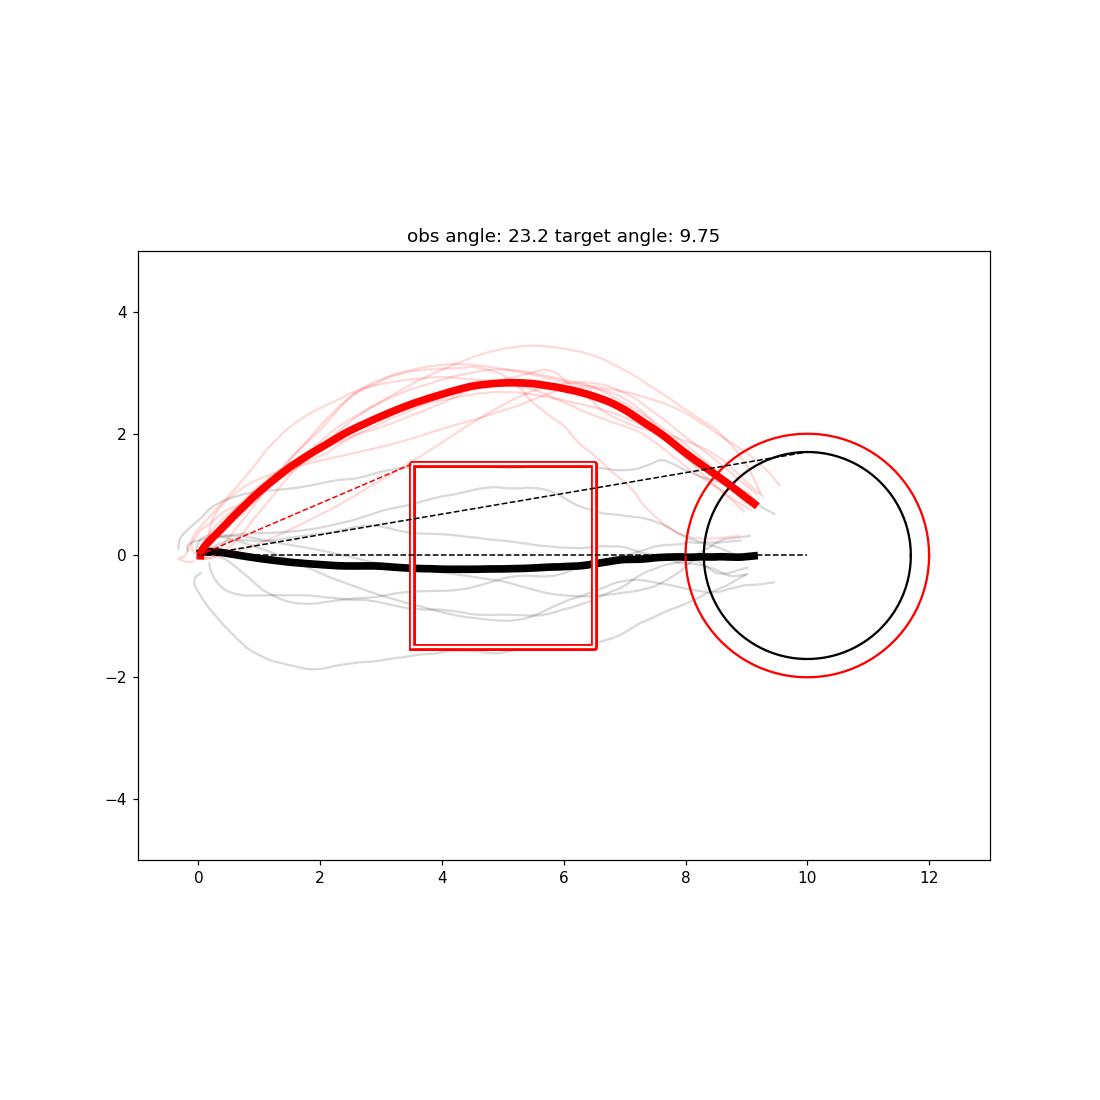

In [148]:
#PLOT PSTH ROTATED AND NEGATED

plt_prefix = 'psth_p_traj_rotate_reflect'
plt_ext = ['.png', '.eps']

plt_len = 100

save_bool = True

rot_t_idx = 3

plt.figure(figsize=plot['size'])
for task in range(num_tasks):
    for i,target in enumerate(pos_psth[task, 'target']):
        x = pos_psth[task, 'kin_px'][i,:]
        y = pos_psth[task, 'kin_py'][i,:]
#             color = target_color[target]
        color = task_color[task]
        plt.plot(x, y, '-', color=color, alpha=0.15, label=task_str + str(target))
        
#     if plot_obs_small:
#         bmi_util.plot_obstacles(obs_pos, target_color, obs_small*np.ones(num_targets))
    if plot_obs_big:
        bmi_util.plot_obstacles(obs_pos[rot_t_idx,:].reshape((1,-1)), 'r', obs_big*np.ones(1))
#         bmi_util.plot_obstacles(obs_pos[rot_t_idx,:].reshape((1,-1)), 'b', obs_big*np.ones(num_targets))
    if plot_target: 
        bmi_util.plot_targets(target_pos[rot_t_idx,:].reshape((1,-1)), task_color[task], target_r_task[task]*np.ones(num_targets))  
    
    
    #PLOT MEAN:
    #---------------------------------------------------------------------------------
    x = pos_psth[task, 'kin_px','mean']
    y = pos_psth[task, 'kin_py', 'mean']
    color = task_color[task]
    plt.plot(x, y, '-', linewidth=5, color=color, label=task_str + str(target))    
    #---------------------------------------------------------------------------------

#PLOT LINES: 
#target line
#target top line
#obstacle top line

#target line: 
target_line_x = [0, target_pos[rot_t_idx,0]]
target_line_y = [0, target_pos[rot_t_idx,1]]
plt.plot(target_line_x, target_line_y, '--', linewidth=1, color='k')

#target top line: 
target_top_line_x = np.copy(target_line_x)
target_top_line_y = [0, target_r_task[0]]
plt.plot(target_top_line_x, target_top_line_y, '--', linewidth=1, color='k')

#obstacle top line: 
obs_top_line_x = [0, 5-obs_big/2.0]
obs_top_line_y = [0, obs_big/2.0]
plt.plot(obs_top_line_x, obs_top_line_y, '--', linewidth=1, color='r')
    
plt.axis('square')
#     plt.legend()
#     plt.title(task_str)
plt.xlim(np.array([-1.0, 13.0]))
plt.ylim(np.array([-5,5]))
#     plt.xlim(plot['xlim'])
#     plt.ylim(plot['ylim'])

target_theta_deg = np.around(theta_max*180/np.pi, 2)
obs_theta_deg = np.around(obs_theta*180/np.pi, 2)
plt.title('obs angle: ' + str(obs_theta_deg) + ' target angle: ' + str(target_theta_deg))
plt.show()
#---------------------------------------------------------------------------------------------
if save_bool:
    plt_name = plt_prefix
    for ext in plt_ext:
        plt.savefig(os.path.join(save_dir, plt_name+ext))       

<IPython.core.display.Javascript object>


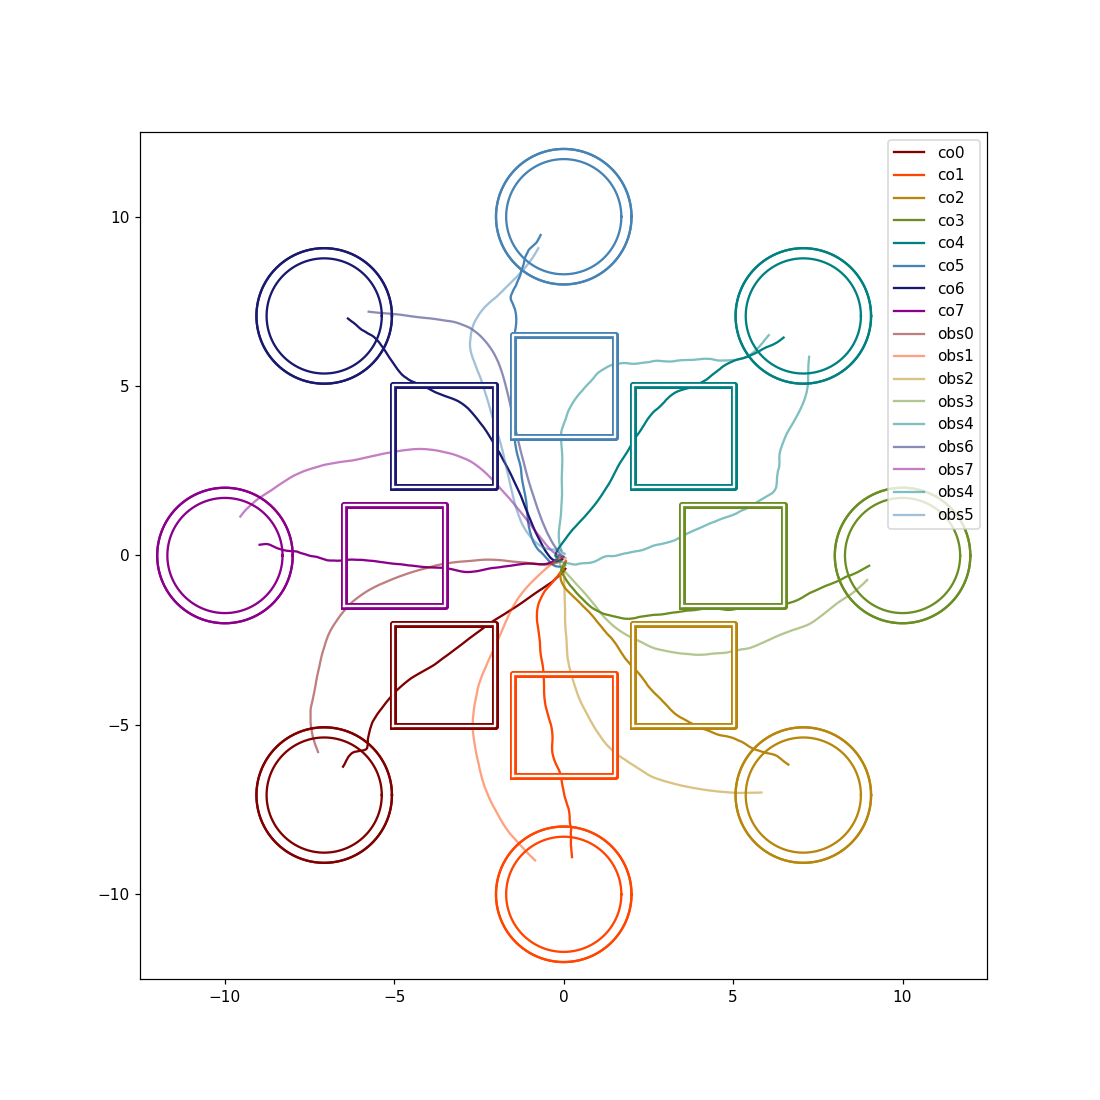

In [63]:
#PLOT PSTH
plt_prefix = 'psth_p_traj'
plt_ext = ['.png', '.eps']

plt_len = 100

save_bool = False

plt.figure(figsize=plot['size'])
for task_cond in task_cond_list:
    task_str = task_cond[0]
    task = task2idx[task_str]
    cw = task_cond[1]
    
    for target in range(num_targets):
        data = psth_dic[task_cond,target,'mean']
        count = psth_dic[task_cond,target,'N']
        
        if (count > 0):# and (task_str == 'obs') and (not cw):
            x = data.loc['kin_px'][:plt_len] #num_time X num_trials
            y = data.loc['kin_py'][:plt_len]
            color = target_color[target]
            plt.plot(x, y, '-', color=color, alpha=1-task*0.5, label=task_str + str(target))
            
    if plot_obs_small:
        bmi_util.plot_obstacles(obs_pos, target_color, obs_small*np.ones(num_targets))
    if plot_obs_big:
        bmi_util.plot_obstacles(obs_pos, target_color, obs_big*np.ones(num_targets))
    if plot_target: 
        bmi_util.plot_targets(target_pos, target_color, target_r_task[task]*np.ones(num_targets))  
    
    plt.axis('square')
    plt.legend()
#     plt.title(task_str)
    plt.xlim(plot['xlim'])
    plt.ylim(plot['ylim'])
    plt.show()
    
    #---------------------------------------------------------------------------------------------
    if save_bool:
        plt_name = plt_prefix + '_' + idx2task[task]
        for ext in plt_ext:
            plt.savefig(os.path.join(save_dir, plt_name+ext))    

### Code used to figure out if trajectory is cw or ccw:

<IPython.core.display.Javascript object>


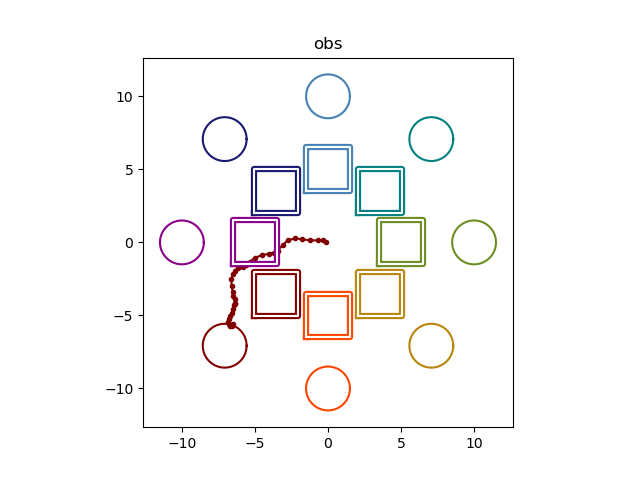

[2947 2982]


In [150]:
#Plot a specific trajectory: 
#PLOT INDIVIDUAL TRIALS: 

target_list = [0]
trial_list = [0]#[25]
#25

plt.figure()
for task_str in ['obs']:#task_list:
    task = task2idx[task_str]
    for target in target_list: #range(num_targets):
        #------------------------------------------------------------------------------------
        #TRIALS: 
        trial_start = np.where((df['trial_start']==1) & (df['target']==target) & (df['task']==task))[0]
        trial_stop = np.where((df['trial_stop']==1) & (df['target']==target) & (df['task']==task))[0]
        trial_bound = np.vstack((trial_start,trial_stop)).T
        num_trials = trial_bound.shape[0]
        #------------------------------------------------------------------------------------
        plot_trial_bound = trial_bound[trial_list,:]
        for bnd in plot_trial_bound: #trial_bound[0:1,:]:
            print(bnd)
            x = df['kin_px'][bnd[0]:bnd[1]+1]
            y = df['kin_py'][bnd[0]:bnd[1]+1]
#             print(x)
            color = target_color[target]
            plt.plot(x,y,'.-',color=color)

    if plot_obs_small:
        bmi_util.plot_obstacles(obs_pos, target_color, obs_small*np.ones(num_targets))
    if plot_obs_big:
        bmi_util.plot_obstacles(obs_pos, target_color, obs_big*np.ones(num_targets))
    if plot_target: 
        bmi_util.plot_targets(target_pos, target_color, target_r_eff[task]*np.ones(num_targets))  
    
    plt.axis('square')
    plt.title(task_str)
#     plt.xlim(plot['xlim'])
#     plt.ylim(plot['ylim'])
    plt.show()        
        
        


In [153]:
df.iloc[2947]

n_0                        0.000000e+00
n_1                        0.000000e+00
n_2                        0.000000e+00
n_3                        0.000000e+00
n_4                        1.000000e+00
n_5                        4.000000e+00
n_6                        1.000000e+00
n_7                        0.000000e+00
n_8                        0.000000e+00
n_9                        0.000000e+00
n_10                       0.000000e+00
n_11                       3.000000e+00
n_12                       0.000000e+00
n_13                       0.000000e+00
n_14                       0.000000e+00
n_15                       1.000000e+00
n_16                       0.000000e+00
n_17                       1.000000e+00
n_18                       2.000000e+00
n_19                       0.000000e+00
n_20                       1.000000e+00
n_21                       1.000000e+00
n_22                       0.000000e+00
n_23                       3.000000e+00
n_24                       0.000000e+00


<IPython.core.display.Javascript object>


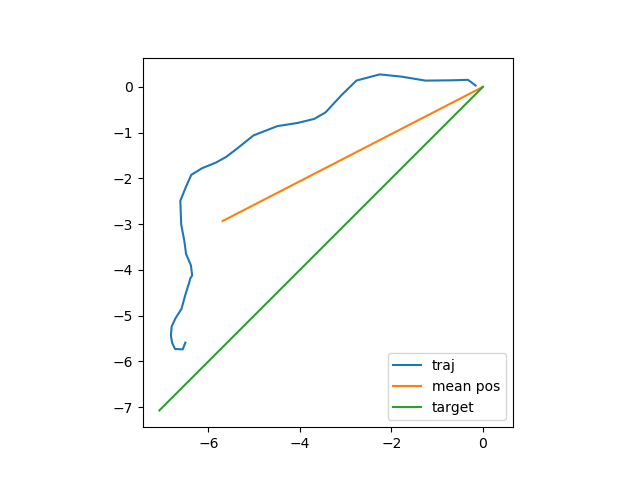

('signed area: ', -18.10939469950846)


<IPython.core.display.Javascript object>


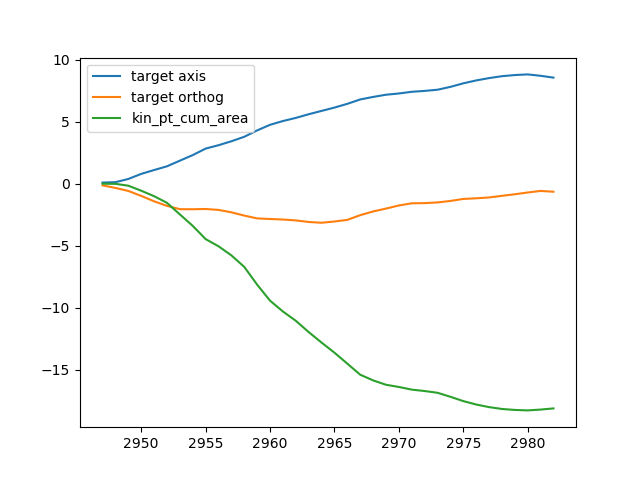

<IPython.core.display.Javascript object>


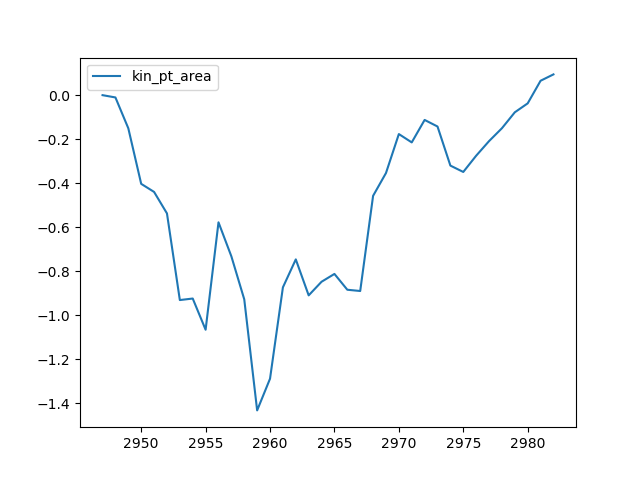

In [151]:
#For each trial, calculate signed "area" between trajectory and the line connecting center and target.  
# (could even have a timeseries of this area.  )
target = 0 #4 
trial_list = [0] #[0, 25]
#interesting case: 23
for trial in trial_list:
    bnd = trial_bound[trial,:]
    x = df.loc[bnd[0]:bnd[1], 'kin_px']
    y = df.loc[bnd[0]:bnd[1], 'kin_py']

    kin = df.loc[bnd[0]:bnd[1], 'kin_px':'kin_py']
    d = np.linalg.norm(kin, axis=1, ord=2)
    kin_mean = kin.loc[d>2, :].mean()
    
    
    plt_x = np.array([0, kin_mean['kin_px']])
    plt_y = np.array([0, kin_mean['kin_py']])

    t_x = np.array([0, target_pos[target,0]])
    t_y = np.array([0, target_pos[target,1]])
    
    plt.figure()                  
    plt.plot(x,y,label='traj')
    plt.plot(plt_x, plt_y, label='mean pos')
    plt.plot(t_x, t_y, label='target')
    plt.axis('square')
    plt.legend()
    
#Calculate signed area: 
t = target_pos[target,:]
a, df_a = bmi_b.traj_signed_area_about_target_axis(x,y,t)
print('signed area: ', a)    

plt.figure()
plt.plot(df_a['kin_pt'], label='target axis')
plt.plot(df_a['kin_pto'], label='target orthog')
plt.plot(df_a['kin_pto_cum_area'], label='kin_pt_cum_area')
plt.legend()

plt.figure()
plt.plot(df_a['kin_pto_area'], label='kin_pt_area')
plt.legend()

<IPython.core.display.Javascript object>


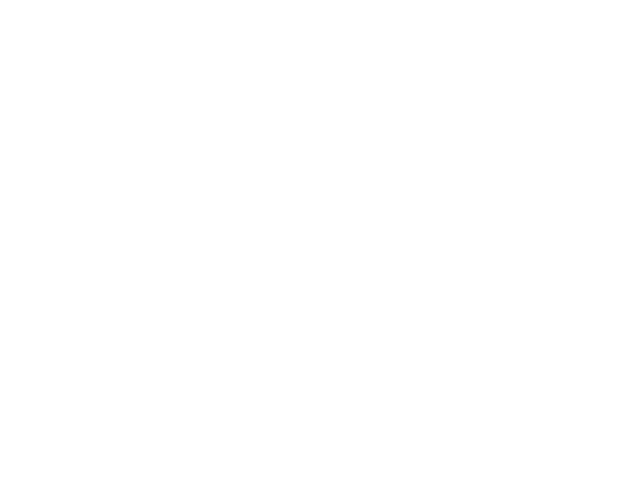

NameError: name 'df_a' is not defined

In [93]:
plt.figure()
plt.plot(df_a['kin_pt'], label='target axis')
plt.plot(df_a['kin_pto'], label='target orthog')
# plt.plot(df_a['kin_pt_cum_area'], label='kin_pt_cum_area')
plt.legend()

plt.figure()
plt.plot(df_a['kin_pt_area'], label='kin_pt_area')

<IPython.core.display.Javascript object>


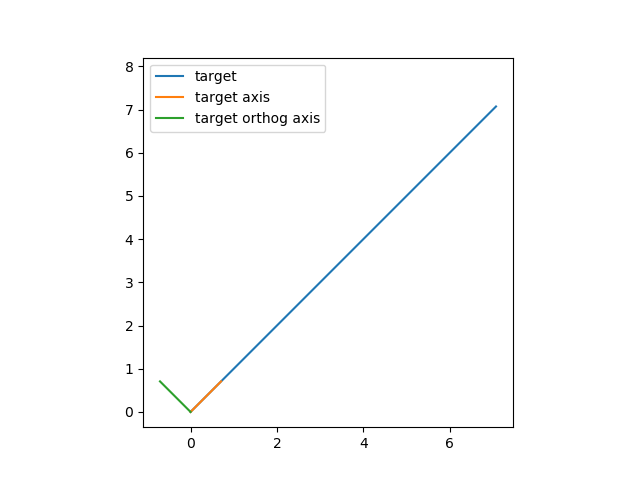

In [110]:
# #TEST target axes
# target = 4
# t = target_pos[target,:]
# t_ax, to_ax = bmi_b.target_axes(t)

# t_x = np.array([0, t[0]])
# t_y = np.array([0, t[1]])

# t_ax_x = np.array([0, t_ax[0]])
# t_ax_y = np.array([0, t_ax[1]])

# to_ax_x = np.array([0, to_ax[0]])
# to_ax_y = np.array([0, to_ax[1]])

# plt.figure()
# plt.plot(t_x, t_y, label='target')
# plt.plot(t_ax_x, t_ax_y, label='target axis')
# plt.plot(to_ax_x, to_ax_y, label='target orthog axis')
# plt.axis('square')
# plt.legend()

[[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]


<IPython.core.display.Javascript object>


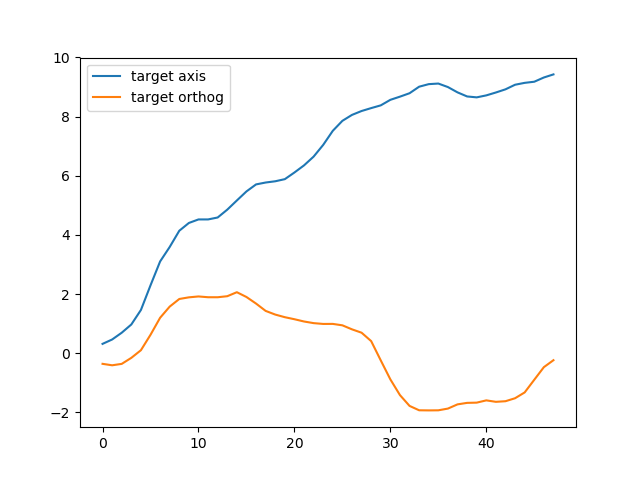

In [109]:
# #TEST target axis projection
# #1) form projection matrix
# #2) plot projections

# proj_mat = np.array([t_ax, to_ax])
# print(proj_mat)
# test = np.dot(proj_mat, kin.T)

# plt.figure()
# plt.plot(test[0], label='target axis')
# plt.plot(test[1], label='target orthog')
# plt.legend()

In [ ]:
#1) Fit regression model on all data
#2) Use it to predict the next step
#3) use that to calculate the estimated u
#3) Re-do the u psth from above, to see if it looks at all good.  

In [151]:
df.head()

n_0  n_1  n_2  n_3  n_4  n_5  n_6  n_7  n_8  n_9  ...  u_p_angle   u_v_mag  \
0  2.0  1.0  0.0  0.0  1.0  4.0  2.0  0.0  0.0  0.0  ...   1.903203  0.979791   
1  2.0  1.0  0.0  0.0  1.0  1.0  0.0  1.0  1.0  0.0  ...   1.343763  2.550964   
2  1.0  1.0  0.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  ...   1.107820  1.538962   
3  5.0  0.0  0.0  1.0  0.0  4.0  4.0  0.0  0.0  0.0  ...  -1.608672  0.868451   
4  4.0  0.0  0.0  0.0  1.0  3.0  0.0  0.0  0.0  0.0  ...   1.202795  1.099681   

   u_v_angle  p_angle_ctr  v_angle_ctr  u_p_angle_ctr  u_v_angle_ctr  \
0   1.903203     3.089594    -2.668033      -2.023787      -2.023787   
1   1.343763     3.107998    -2.663977      -2.583228      -2.583228   
2   1.107820     3.122842    -2.811559      -2.819171      -2.819171   
3  -1.608672     3.121874     2.781544       0.747523       0.747523   
4   1.202795     3.122433    -3.084737      -2.724196      -2.724196   

    d2target    x_error    y_error  
0  18.560671  13.435452  12.805746  
1  18.844048  13.533209  13.112986  
2  19.180040  13.683511  13.440069  
3  19.319563  13.790328  13.530425  
4  19.482174  13.903848  13.646909  

[5 rows x 74 columns]

In [156]:
n_label = ['n_'+str(i) for i in range(num_neurons)]
n = df.loc[:,n_label]


In [161]:
n.head()

n_0  n_1  n_2  n_3  n_4  n_5  n_6  n_7  n_8  n_9  ...  n_34  n_35  n_36  \
0  2.0  1.0  0.0  0.0  1.0  4.0  2.0  0.0  0.0  0.0  ...   2.0   1.0   6.0   
1  2.0  1.0  0.0  0.0  1.0  1.0  0.0  1.0  1.0  0.0  ...   0.0   1.0   7.0   
2  1.0  1.0  0.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  ...   0.0   0.0   4.0   
3  5.0  0.0  0.0  1.0  0.0  4.0  4.0  0.0  0.0  0.0  ...   0.0   0.0   5.0   
4  4.0  0.0  0.0  0.0  1.0  3.0  0.0  0.0  0.0  0.0  ...   2.0   0.0   6.0   

   n_37  n_38  n_39  n_40  n_41  n_42  n_43  
0   7.0   7.0   1.0   1.0   0.0   0.0   6.0  
1   5.0   8.0   1.0   2.0   0.0   0.0   3.0  
2   4.0   6.0   1.0   1.0   0.0   0.0   2.0  
3   3.0   3.0   2.0   2.0   2.0   0.0   1.0  
4   4.0   7.0   0.0   2.0   1.0   0.0   4.0  

[5 rows x 44 columns]

In [160]:
from sklearn.linear_model import LinearRegression

In [180]:
n = df.loc[:, n_label]

n_0 = df.loc[df['task']==0, n_label]
# n_0.head()

n_1 = df.loc[df['task']==1, n_label]
# n_1.head()

In [293]:
#Predict one ahead: 
reg = LinearRegression().fit(n[:-1], n[1:])

# #Predict same: 
# reg = LinearRegression().fit(n[:-1], n[:-1])

In [292]:
#Predict next step
reg.score(n[:-1],n[1:])

-0.31595284327220763

In [289]:
#Predict current step
reg.score(n[1:],n[1:])

0.4615648079343505

In [290]:
#Predict past step
reg.score(n[1:],n[:-1])

0.21063158248996372

In [183]:
#Next, predict one step ahead.  
n_pred = reg.predict(n[:-1])

In [256]:
n.head()

n_0  n_1  n_2  n_3  n_4  n_5  n_6  n_7  n_8  n_9  ...  n_34  n_35  n_36  \
0  2.0  1.0  0.0  0.0  1.0  4.0  2.0  0.0  0.0  0.0  ...   2.0   1.0   6.0   
1  2.0  1.0  0.0  0.0  1.0  1.0  0.0  1.0  1.0  0.0  ...   0.0   1.0   7.0   
2  1.0  1.0  0.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  ...   0.0   0.0   4.0   
3  5.0  0.0  0.0  1.0  0.0  4.0  4.0  0.0  0.0  0.0  ...   0.0   0.0   5.0   
4  4.0  0.0  0.0  0.0  1.0  3.0  0.0  0.0  0.0  0.0  ...   2.0   0.0   6.0   

   n_37  n_38  n_39  n_40  n_41  n_42  n_43  
0   7.0   7.0   1.0   1.0   0.0   0.0   6.0  
1   5.0   8.0   1.0   2.0   0.0   0.0   3.0  
2   4.0   6.0   1.0   1.0   0.0   0.0   2.0  
3   3.0   3.0   2.0   2.0   2.0   0.0   1.0  
4   4.0   7.0   0.0   2.0   1.0   0.0   4.0  

[5 rows x 44 columns]

<IPython.core.display.Javascript object>


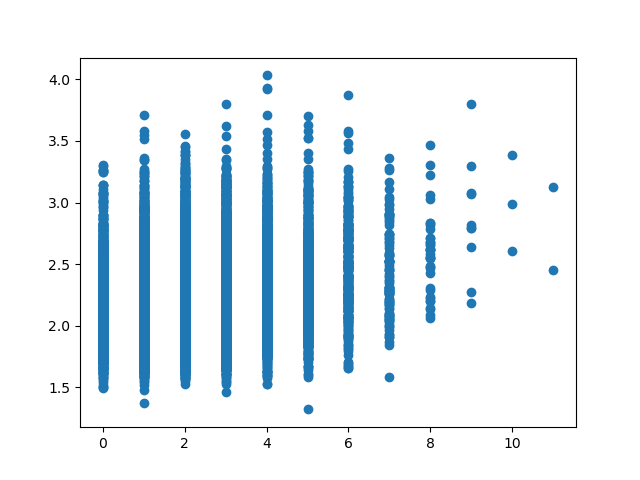

('R2:', 0.15951908023803443, 'p:', 0.0)


In [286]:
#Inspect neuron predictions:
i_n = 5
i_label = 'n_'+str(i_n)

x_t = n.loc[0:n.index[-2], i_label]
x_tp1 = n.loc[1:n.index[-1], i_label]
y = n_pred[:, i_n]


plt.figure()
plt.scatter(x_tp1,y)
plt.title('')

r,p = sio_stat.pearsonr(x_t,y)
print('R2:', r**2, 'p:', p)

In [218]:
#Next, produce predicted u_v:
#0) get decoder
ddec=bmi_util.decompose_decoder(decoder['F'], decoder['K'])
n2u =ddec['K_d']['v'][ddec['var_idxs']['v'],:]
# plt.figure()
# plt.imshow(n2u)

#1) verify it reproduces saved data
u_hat = np.dot(n,n2u.T)
# plt.figure()
# plt.scatter(u_hat[:,0], df['u_vx'])
# plt.figure()
# plt.scatter(u_hat[:,1], df['u_vy'])

#2) predict u:
u_pred = np.dot(n_pred,n2u.T)

F_hat close to F
K_hat close to K


In [236]:
df.head()

n_0  n_1  n_2  n_3  n_4  n_5  n_6  n_7  n_8  n_9  ...  u_p_angle   u_v_mag  \
0  2.0  1.0  0.0  0.0  1.0  4.0  2.0  0.0  0.0  0.0  ...   1.903203  0.979791   
1  2.0  1.0  0.0  0.0  1.0  1.0  0.0  1.0  1.0  0.0  ...   1.343763  2.550964   
2  1.0  1.0  0.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  ...   1.107820  1.538962   
3  5.0  0.0  0.0  1.0  0.0  4.0  4.0  0.0  0.0  0.0  ...  -1.608672  0.868451   
4  4.0  0.0  0.0  0.0  1.0  3.0  0.0  0.0  0.0  0.0  ...   1.202795  1.099681   

   u_v_angle  p_angle_ctr  v_angle_ctr  u_p_angle_ctr  u_v_angle_ctr  \
0   1.903203     3.089594    -2.668033      -2.023787      -2.023787   
1   1.343763     3.107998    -2.663977      -2.583228      -2.583228   
2   1.107820     3.122842    -2.811559      -2.819171      -2.819171   
3  -1.608672     3.121874     2.781544       0.747523       0.747523   
4   1.202795     3.122433    -3.084737      -2.724196      -2.724196   

    d2target    x_error    y_error  
0  18.560671  13.435452  12.805746  
1  18.844048  13.533209  13.112986  
2  19.180040  13.683511  13.440069  
3  19.319563  13.790328  13.530425  
4  19.482174  13.903848  13.646909  

[5 rows x 74 columns]

<IPython.core.display.Javascript object>


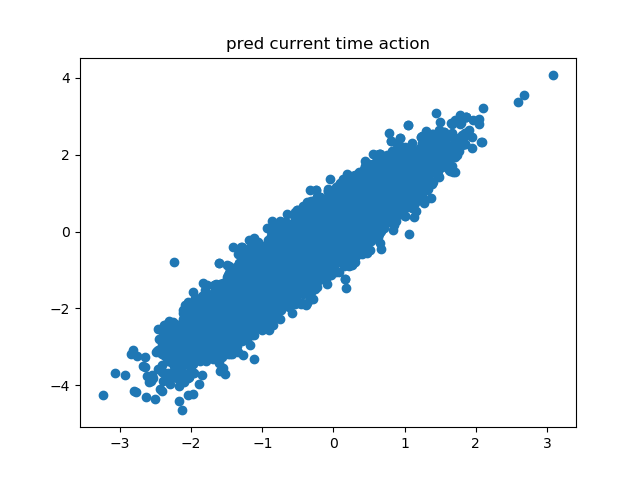

('R2:', 0.8670548948492816, 'p:', 0.0)


<IPython.core.display.Javascript object>


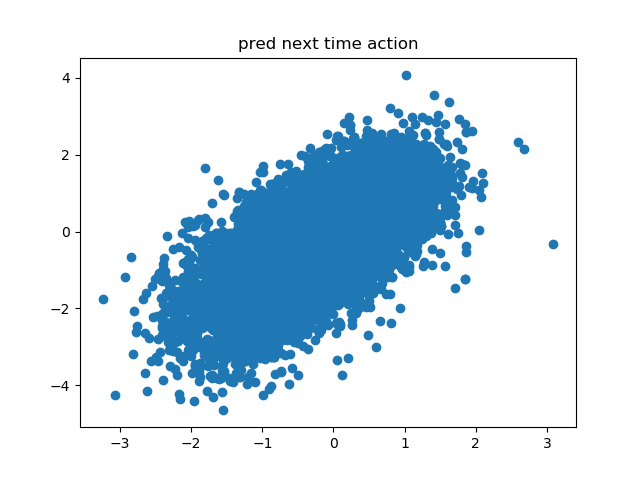

('R2:', 0.46061196383520703, 'p:', 0.0)


<IPython.core.display.Javascript object>


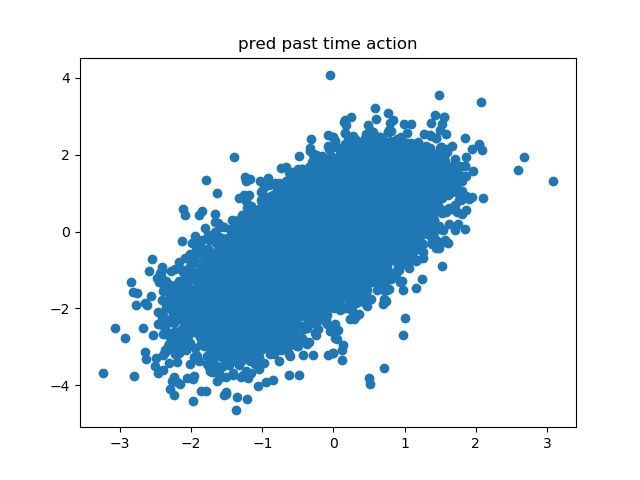

('R2:', 0.4613576255912734, 'p:', 0.0)


In [294]:
#Test prediction against 
x = u_pred[:,0]
y = df.loc[df.index[0]:df.index[-2],'u_vx']
plt.figure()
plt.scatter(x, y)
plt.title('pred current time action')
r,p = sio_stat.pearsonr(x,y)
print('R2:', r**2, 'p:', p)

x = u_pred[:,0]
y = df.loc[df.index[1]:df.index[-1],'u_vx']
plt.figure()
plt.scatter(x, y)
plt.title('pred next time action')
r,p = sio_stat.pearsonr(x,y)
print('R2:', r**2, 'p:', p)

x = u_pred[1:,0]
y = df.loc[df.index[0]:df.index[-3],'u_vx']
plt.figure()
plt.scatter(x, y)
plt.title('pred past time action')
r,p = sio_stat.pearsonr(x,y)
print('R2:', r**2, 'p:', p)
# print(sio_stat.pearsonr())
# plt.figure()
# plt.scatter(u_pred[:,0], df.loc[1:,'u_vx'])

In [295]:
#Next, redo the psth analysis: 
df_hat = df.copy()
df_hat.loc[1:,'u_vx'] = u_pred[:,0]
df_hat.loc[1:,'u_vy'] = u_pred[:,1]

In [296]:
# 1) Convert stuff to polar, 2) center angles at target angle, 3) calculate distance to target

df_hat['u_v_mag'], df_hat['u_v_angle'] = bmi_b.cartesian2polar(df_hat['u_vy'], df_hat['u_vx'])
# 2) Center @ target angle: 
d_list = ['u_v_angle']
for d in d_list:
    data = df_hat[d]
    zeros = np.zeros(data.shape)
    t_angle = target_angle[df_hat['target'].astype(int)]
    df_hat[d+'_ctr'] = bmi_b.center_angle(df_hat[d], zeros, t_angle)
# 3) distance to target
error = df_hat.loc[:, 'kin_px':'kin_py']-target_pos[df_hat['target'].astype(int),:]
df_hat['d2target'] = np.linalg.norm(error,ord=2,axis=1)
df_hat['x_error'] = error.loc[:,'kin_px']
df_hat['y_error'] = error.loc[:,'kin_py']


In [297]:
# df_orig = df.copy()
df = df_hat
#INTERPOLATED PSTH:
#TRIALS GO FROM START TO TIME CURSOR HITS TARGET BOUNDARY
#FORM: xarray for variable x time x trial: 

#(1.7 - 0.4 = 1.3 for CO, and 2.0 - 0.5 = 1.5 for OBS).
target_r_eff = {0:1.3, 1:1.5}
num_var = df.shape[1]
num_interp_pts = 100
time_win = np.array([0, num_interp_pts])
num_time = np.diff(time_win)[0]
da_dic = {}
for task_str in task_list:
    task = task2idx[task_str]
    for target in range(num_targets):
        #------------------------------------------------------------------------------------
        #TRIALS: 
        trial_start = np.where((df['trial_start']==1) & (df['target']==target) & (df['task']==task))[0]
        trial_stop = np.where((df['trial_stop']==1) & (df['target']==target) & (df['task']==task))[0]
        trial_bound = np.vstack((trial_start,trial_stop)).T
        num_trials = trial_bound.shape[0]
        #------------------------------------------------------------------------------------
        #Initialize a nan-filled xarray
        nan_mat = np.ones((num_var, num_time, num_trials))*np.nan
        da = xr.DataArray(nan_mat,
                    coords={'var':list(df.columns),
                                     'time':range(num_time),
                                     'trial':range(num_trials)},
                    dims=['var','time','trial'])
        for trial, bnd in enumerate(trial_bound): #trial_bound[0:1,:]:
            d2target = df.loc[bnd[0]:bnd[1],'d2target']
            end = bnd[0]+np.where(d2target <= target_r_eff[task])[0][0]
            trial_len = end-bnd[0]+1
            #Linearly interpolate the trial: 
            d_trial = np.array(df.loc[bnd[0]:end,:])
            x = np.arange(0,trial_len)
            f = scipy.interpolate.interp1d(x,d_trial,axis=0)
            x_interp = np.linspace(x[0],x[-1],num_interp_pts)
            d_interp = f(x_interp).T
            da[:,:,trial] = d_interp
        da_dic[(task,target)] = da      

In [298]:
# Average mag, abs angle
ctrl_psth = {}
d_list = ['u_v_mag', 'u_v_angle_ctr']
num_orient_samples = 50
for task in range(num_tasks):
    for d in d_list:
        d_mat = np.zeros((num_targets, num_time))
        d_mat = np.ma.array(d_mat)
        for target in range(num_targets):
            mean = psth_dic[task,target,'mean'].loc[d]
            #ctrl_psth[task,target,d,'mean']
            if 'angle' in d: 
                if np.sum(mean[:num_orient_samples]) > 0:
                    mean = -mean
                #want the absolute angle                
            d_mat[target,:] = mean
        #PSTH:         
#         mean = d_mat.mean(axis=0)
#         N = np.logical_not(np.isnan(d_mat)).sum(axis=0)
#         var = data.var(axis=1)
#         sem = (var/N)**(0.5)        
        ctrl_psth[task,d,'mat'] = d_mat
        ctrl_psth[task,d,'mean'] = d_mat.mean(axis=0)
        ctrl_psth[task,d,'var'] = d_mat.var(axis=0)
        ctrl_psth[task,d,'sem'] = sio_stat.sem(d_mat, axis=0, nan_policy='omit')

In [300]:
#Exclude a target:
task = 1
for d in d_list: 
    d_mat = ctrl_psth[task,d,'mat'][[0,1,2,3,5,6,7],:]
    ctrl_psth[task,d,'mean'] = d_mat.mean(axis=0)
    ctrl_psth[task,d,'var'] = d_mat.var(axis=0)
    ctrl_psth[task,d,'sem'] = sio_stat.sem(d_mat, axis=0, nan_policy='omit')    

<IPython.core.display.Javascript object>


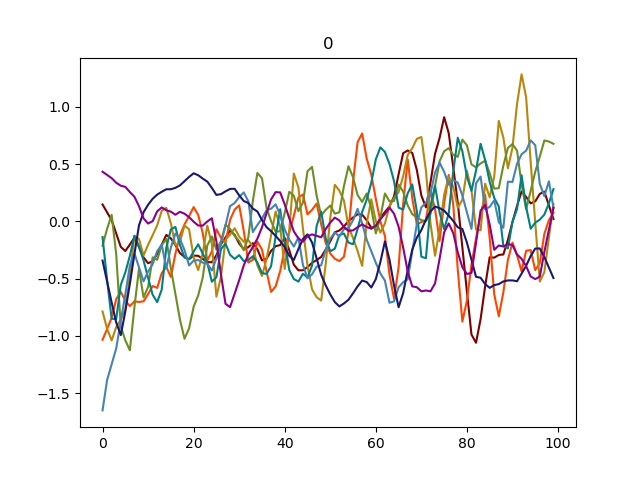

<IPython.core.display.Javascript object>


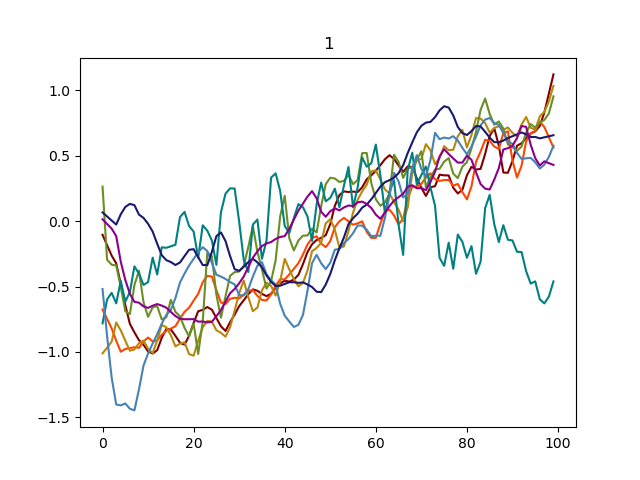

In [301]:
d_list = ['u_v_angle_ctr']
for task in range(num_tasks):
    plt.figure()
    for d in d_list:
        y_mat = ctrl_psth[task,d,'mat']
        for target in range(num_targets):
            plt.plot(y_mat[target,:], color=target_color[target])
    plt.title(task)

In [1]:
save_dir

NameError: name 'save_dir' is not defined

<IPython.core.display.Javascript object>


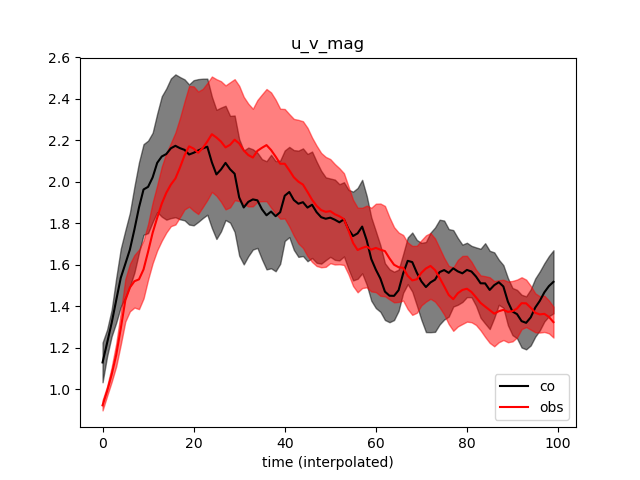

<IPython.core.display.Javascript object>


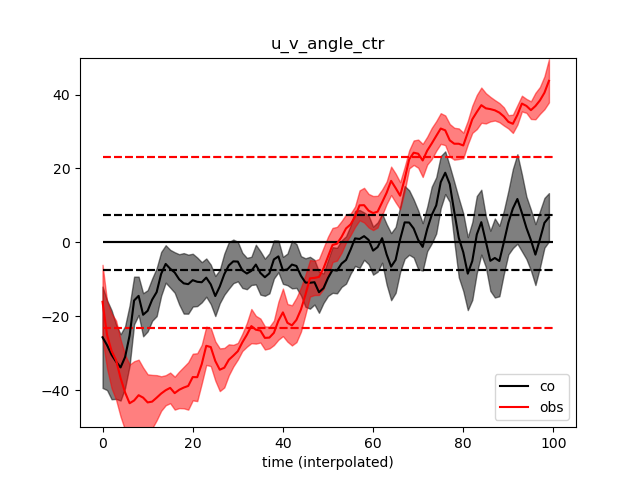

In [20]:
save_bool = True
plt_prefix = 'psth_interp'
plt_ext = ['.eps']

d_list = ['u_v_mag', 'u_v_angle_ctr']
plot_len = 100
for d in d_list:
    plt.figure()
    for task in range(num_tasks):
        y_mean = ctrl_psth[task,d,'mean'][:plot_len]
        y_sem = ctrl_psth[task,d,'sem'][:plot_len]
        if 'angle' in d:
            y = y*180/np.pi
            y_mean = y_mean*180/np.pi
            y_sem = y_sem*180/np.pi 
            plt.hlines(0,0,plot_len,color='k')
            plt.hlines(theta_max*180/np.pi,0,plot_len,color='k',linestyles='dashed')
            plt.hlines(-theta_max*180/np.pi,0,plot_len,color='k',linestyles='dashed')
            
            plt.hlines(obs_theta*180/np.pi,0,plot_len,color='r',linestyles='dashed')
            plt.hlines(-obs_theta*180/np.pi,0,plot_len,color='r',linestyles='dashed')            
            
            plt.legend()
        plt.plot(y_mean, color=task_color[task],label=idx2task[task])
        plt.fill_between(range(len(y_mean)), y_mean-y_sem,y_mean+y_sem,alpha=0.5,color=task_color[task])
    plt.xlabel('time (interpolated)')
    plt.title(d)
    plt.legend(loc = 'lower right')
    if 'angle' in d:
        plt.ylim(-50,50)
#         plt.axis('square')
    
        
    if save_bool: 
        plt_name = plt_prefix + '_' + d
        for ext in plt_ext:
            plt.savefig(os.path.join(save_dir, plt_name+ext))